## June 2023 Data Reduction

### 1D Waterfall Cascade Plot

/var/folders/5h/c94dty5j5lbgtxxpsfrx5k2c0000gn/T/ipykernel_24729/3545062935.py:98: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(colorscale)


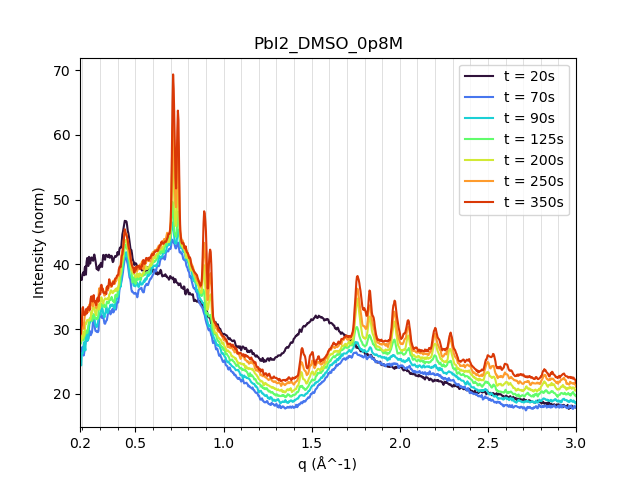

In [36]:
import os
import gc
import glob
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
%matplotlib widget

def grabpaths(data_folder, globStr):
    """ Grab all of the files from the input data folder with specification from the searchString. (Default) searchString = '*_[0-9][0-9][0-9][0-9]_maxs.tiff' """
    file_paths = [] # list that will store the file paths used for analysis
    file_paths = sorted(glob.iglob(data_folder + globStr)) # Uses 'glob.iglob' to match the phrase and grab data file paths that are indexed with the specified identifier.
    return file_paths

def metadataminer(datapath, keylist, prev_clocktime):
    # /Users/keithwhite/github_repositories/giwaxs_suite/data_files/1MAI1PbI2_DMF0p3M/sam22_1MAI1PbI2_unfilt_0p3M_5p0scfh_Si_30uL_043_2068.2s_x0.015_th0.300_0.49s_986546_000030_maxs.tiff
    file_dict = {}

    filename = os.path.splitext(datapath)[0] + '.csv'  # strip file name from the path
    basename = os.path.basename(filename)  # create basepath name
    minedvallist = basename.split("_")

    file_dict = dict(zip(keylist, minedvallist))

    file_dict['filename'] = filename
    file_dict['basename'] = basename  # store the basename

    # - Get Time: clocktime and exptime
    clocktime = file_dict.get('clocktime', '0')
    clocktime = re.findall(r"\d+\.\d+", clocktime)
    clocktime = clocktime[0] if clocktime else '0'
    file_dict['clocktime'] = clocktime

    exptime = file_dict.get('exptime', '0')
    exptime = re.findall(r"\d+\.\d+", exptime)
    exptime = str(np.round(float(exptime[0]), 1)) if exptime else '0'  # round exposure time to nearest decimal place
    file_dict['exptime'] = exptime

    framenum = file_dict.get('framenum', '0')
    # framenum = re.findall(r"\d+\.\d+", framenum)
    # framenum = framenum[0] if framenum else '0'
    file_dict['framenum'] = framenum

    # - Get Position: xpos and thpos
    xpos = file_dict.get('xpos', '0')
    xpos = re.findall(r"\d+\.\d+", xpos)
    xpos = xpos[0] if xpos else '0'
    file_dict['xpos'] = xpos

    thpos = file_dict.get('thpos', '0')
    thpos = re.findall(r"\d+\.\d+", thpos)
    thpos = thpos[0] if thpos else '0'
    file_dict['thpos'] = thpos

    if prev_clocktime == 0 or prev_clocktime is not None or not np.isnan(prev_clocktime):
        clocktime_diff = 0
    else:
        clocktime_diff = float(clocktime) - prev_clocktime
        prev_clocktime = float(clocktime)

    # print ('Exp Time: ' + str(exptime) + ', Frame Num: ' + str(framenum))

    measuretime = clocktime_diff + (float(exptime) * float(framenum))
    file_dict['measuretime'] = str(measuretime)

    return file_dict, prev_clocktime

def plot_waterfall(folder_paths, samplenames, keylists, colorscale='turbo'):
    plt.close('all')
    gc.collect()

    for folder_path, samplename, keylist in zip(folder_paths, samplenames, keylists):
        plt.close('all')
        os.chdir(folder_path)

        filenames = sorted(glob.glob('*.csv'))
        filepaths = grabpaths(folder_path, '*.csv')

        # Create the save folder for waterfall analysis
        save_folder = os.path.join(folder_path, f'waterfall1D_{int(time.time())}')
        os.makedirs(save_folder, exist_ok=True)

        measure_times = []
        prev_clocktime = 0

        for i, filepath in enumerate(filepaths):
            filepath = filepaths[i]
            file_dict, prev_clocktime = metadataminer(filepath, keylist, prev_clocktime)
            # print('Folder: ' + folder_path)
            measure_time = file_dict['measuretime']
            measure_time = float(measure_time)
            measure_times.append(measure_time)

            data = np.loadtxt(filepath, delimiter=',', skiprows=1)

            cmap = get_cmap(colorscale)
            color = cmap(i / len(filenames))
            plt.plot(data[:, 0], data[:, 1] + i, color=color)

        # Add a legend for each trace
        for i, (filename, t) in enumerate(zip(filenames, measure_times)):
            plt.plot([], [], color=cmap(i / len(filenames)), label=f't = {int(t)}s')

        plt.legend()

        plt.title(samplename)
        plt.xlabel('q (Å^-1)')
        plt.ylabel('Intensity (norm)')
        plt.xlim(np.min(data[:, 0]), np.max(data[:, 0]))

        # Add text annotations for measurement times
        for i, t in enumerate(measure_times):
            plt.annotate(f't = {t:.2f}s', (0, i), xytext=(5, 0), textcoords='offset points', va='center')

        # Set the tick locations and labels for the x-axis
        xticks_large = np.arange(np.floor(np.min(data[:, 0])), np.ceil(np.max(data[:, 0])) + 0.5, 0.5)
        xticks_small = np.arange(np.floor(np.min(data[:, 0])), np.ceil(np.max(data[:, 0])) + 0.1, 0.1)
        plt.xticks(xticks_large, rotation=0)
        plt.xticks(xticks_small, minor=True)

        # Display the values at the limits of the x-axis
        xticks = np.append(plt.xticks()[0], [np.min(data[:, 0]), np.max(data[:, 0])])
        plt.xticks(xticks, [f'{x:.1f}' for x in xticks])
        plt.xlim(np.min(data[:, 0]), np.max(data[:, 0]))

        # Add light gray grid lines at major and minor tick marks
        plt.grid(True, which='both', axis='x', color='lightgray', linewidth=0.5, zorder=0)

        # Save the plot
        plot_filename = os.path.join(save_folder, f'waterfall_{samplename}.png')
        plt.savefig(plot_filename)


    # Show the plot after all sets have been processed
    plt.show()

folder_paths = ['/Users/keithwhite/github_repositories/giwaxs_suite/data_files/analysis/1MAI1PbI2_DMF_0p3M_20230606_084514/azimuth1d/',
        '/Users/keithwhite/github_repositories/giwaxs_suite/data_files/analysis/PbI2_DMF_0p5M_20230606_085426/azimuth1d/',
        '/Users/keithwhite/github_repositories/giwaxs_suite/data_files/analysis/1MAI1PbI2_DMF_0p05M_20230606_085608/azimuth1d/',
        '/Users/keithwhite/github_repositories/giwaxs_suite/data_files/analysis/1MAI1PbI2_DMF_1M_20230606_085829/azimuth1d/',
        '/Users/keithwhite/github_repositories/giwaxs_suite/data_files/analysis/3MAI1PbI2_DMF_0p3M_20230606_090026/azimuth1d/',
        '/Users/keithwhite/github_repositories/giwaxs_suite/data_files/analysis/3MAI1PbI2_DMF_0p05M_20230606_090310/azimuth1d/',
        '/Users/keithwhite/github_repositories/giwaxs_suite/data_files/analysis/3MAI1PbI2_DMF_1M_20230606_090634/azimuth1d/',
        '/Users/keithwhite/github_repositories/giwaxs_suite/data_files/analysis/PbI2_DMF_0p05M_20230606_090937/azimuth1d/',
        '/Users/keithwhite/github_repositories/giwaxs_suite/data_files/analysis/PbI2_DMSO_0p8M_20230606_091315/azimuth1d/']

samplenames = ['1MAI1PbI2_DMF_0p3M',  # keylist2
               'PbI2_DMF_0p5M',  # keylist3
               '1MAI1PbI2_DMF_0p05M',  # keylist1
               '1MAI1PbI2_DMF_1M',  # keylist2
               '3MAI1PbI2_DMF_0p3M',  # keylist2
               '3MAI1PbI2_DMF_0p05M',  # keylist1
               '3MAI1PbI2_DMF_1M',  # keylist2
               'PbI2_DMF_0p05M',  # keylist1
               'PbI2_DMSO_0p8M']  # keylist1

# Example 1: sam34_1MAI1PbI2_DMF_0p05M_unfilt_5p0scfh_Si_40uL_064_1524.8s_x0.002_th0.300_0.49s_987540_000040_maxs_0.0_2dcake_20230606_085608.csv
keylist1 = ['solutionnum', 'composition', 'solvsys', 'molarity', 'filtopt', 'purgerate', 'sub', 'solvol', 'sampnum', 'clocktime', 'xpos', 'thpos', 'exptime', 'scanid', 'framenum', 'detector', 'setnum', 'plottype', 'date', 'time']
# Example 2: sam22_1MAI1PbI2_unfilt_0p3M_5p0scfh_Si_30uL_043_2068.2s_x0.015_th0.300_0.49s_986546_000030_maxs_0.0_azimuth1d_20230606_084514.csv
keylist2 = ['solutionnum', 'composition', 'filtopt','molarity', 'purgerate', 'sub', 'solvol', 'sampnum', 'clocktime', 'xpos', 'thpos', 'exptime', 'scanid', 'framenum', 'detector', 'setnum', 'plottype', 'date', 'time']
# Example 3: sam3_pbi2dmf0p5M_unfilt_5p0scfh_Si_30uL_036_2090.2s_x0.010_th0.300_0.49s_986266_000020_maxs_0.0_azimuth1d_20230606_085426.csv
keylist3 = ['solutionnum', 'chemistry', 'filtopt','purgerate', 'sub', 'solvol', 'sampnum', 'clocktime', 'xpos', 'thpos', 'exptime', 'scanid', 'framenum', 'detector', 'setnum', 'plottype', 'date', 'time']

keylists = [keylist2, keylist3, keylist1, keylist3, keylist2, keylist1, keylist2, keylist1, keylist1]

plot_waterfall(folder_paths, samplenames, keylists, colorscale='turbo')


### Arithmetic Series Analysis Widget

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.signal import find_peaks
from tkinter import Tk
from tkinter.filedialog import askopenfilename
from collections import defaultdict
from IPython.display import clear_output
from PyQt5.QtWidgets import QApplication, QWidget, QVBoxLayout, QCheckBox, QPushButton, QLabel, QScrollArea
%matplotlib widget

# Clear all outputs
clear_output(wait=True)

# Create a root window and hide it
Tk().withdraw()

# Open a file dialog and get the file path
file_path = askopenfilename(filetypes=[('.xy files', '*.xy'), ('.int files', '*.int')], title='Select .xy or .int file')

# Check if the file dialog was closed without selecting a file
if file_path == '':
    print("No file selected!")
else:
    # Check if the file exists
    if not os.path.isfile(file_path):
        print(f"File {file_path} does not exist!")
    else:
        # Load the data from the file, skipping the first two lines
        data = np.loadtxt(file_path, skiprows=2)

        # Assuming the file has three columns, first for '2θ' (in degrees), second for 'intensity', third is ignored
        two_theta_degrees = data[:, 0]
        intensity = data[:, 1]

        # Convert 2θ from degrees to radians
        two_theta_radians = np.radians(two_theta_degrees)

        # Define the wavelength (λ)
        wavelength = 0.976  # in Angstroms

        # Calculate q from 2θ
        q_values = 4 * np.pi * np.sin(two_theta_radians / 2) / wavelength

        # Normalize the intensity to its maximum value
        intensity_normalized = intensity / np.max(intensity)

        # Define a mask for data where q is greater than or equal to 0.1
        mask = q_values >= 0.1
        
        # Apply the mask to q_values and intensity_normalized
        q_values = q_values[mask]
        intensity_normalized = intensity_normalized[mask]

        # Define a threshold for peak detection
        peak_threshold = 0.002  # Peaks should be at least 80% of the maximum intensity

        # Find the peaks above the threshold
        peaks, _ = find_peaks(intensity_normalized, height=peak_threshold)

        # Initialize empty lists to store q-values and intensities of peaks
        peak_q_values = []
        peak_intensities = []

        for peak in peaks:
            peak_q_values.append(q_values[peak])
            peak_intensities.append(intensity_normalized[peak])

        # Find all pairs of q-values and group them by difference
        diffs = defaultdict(list)
        for i in range(len(peak_q_values)):
            for j in range(i+1, len(peak_q_values)):
                diff = peak_q_values[j] - peak_q_values[i]
                diffs[diff].append((i, j))

        # Define a tolerance for the difference (e.g., 5%)
        tolerance = 0.05

        # Group the pairs with similar differences together
        diff_sets = defaultdict(list)
        for diff1, pairs1 in diffs.items():
            for diff2, pairs2 in diffs.items():
                if abs(diff1 - diff2) / diff1 <= tolerance:
                    diff_sets[diff1].extend(pairs1 + pairs2)

        # Only keep the unique pairs in each set
        diff_sets = {diff: list(set(pairs)) for diff, pairs in diff_sets.items()}

        # Only keep the pairs that appear more than once
        diff_sets = {diff: pairs for diff, pairs in diff_sets.items() if len(pairs) > 1}

        # PyQt5 Application
        app = QApplication([])
        window = QWidget()
        layout = QVBoxLayout()

        # Create a dictionary to hold the QCheckBoxes
        checkboxes = {}

        # Add checkboxes to layout
        for diff, pairs in diff_sets.items():
            cb = QCheckBox(f"Set with approximate difference {diff}")
            layout.addWidget(cb)
            checkboxes[diff] = cb

        # Button for plotting
        plot_button = QPushButton("Plot")
        layout.addWidget(plot_button)

        def on_plot_button_clicked():
            selected_diffs = [diff for diff, cb in checkboxes.items() if cb.isChecked()]

            if not selected_diffs:  # If no sets are selected, plot all peaks
                peak_indices = list(range(len(peak_q_values)))
            else:  # If some sets are selected, only plot the peaks in those sets
                peak_indices = []
                for selected_diff in selected_diffs:
                    pairs = diff_sets[selected_diff]
                    for i, _ in pairs:
                        if i not in peak_indices:
                            peak_indices.append(i)

            # Plotting
            plt.figure(figsize=(10, 6))
            plt.plot(q_values, intensity_normalized, label='Data')
            plt.yscale('log')

            for idx, i in enumerate(sorted(peak_indices)):
                plt.plot(peak_q_values[i], peak_intensities[i], "ro")
                plt.text(peak_q_values[i], peak_intensities[i], f"{idx+1} ({peak_q_values[i]:.2f})")

            # Set the x and y axis labels
            plt.xlabel('q (Å$^{-1}$)')
            plt.ylabel('Log Intensity (arb. units)')

            plt.xlim(0.1,3.5)
            plt.ylim(2e-3, 1)

            plt.title('Normalized Log Intensity')
            plt.legend()
            plt.show()

        plot_button.clicked.connect(on_plot_button_clicked)

        window.setLayout(layout)
        window.show()
        app.exec_()


### tr-GIWAXS

In [ ]:
import nslsii_11bmcms_funclib as WAXS

datafolders1 = ['/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_solvsys_molar_filt_purgerate_sub_solvol_sampnum/sam12_PbI2_DMSO_0p8M_unfilt_5p0scfh_Si_40uL_062/maxs/raw/', 
                '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_solvsys_molar_filt_purgerate_sub_solvol_sampnum/sam33_3MAI1PbI2_DMF_0p05M_unfilt_5p0scfh_Si_40uL_063/maxs/raw/', 
                '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_solvsys_molar_filt_purgerate_sub_solvol_sampnum/sam34_1MAI1PbI2_DMF_0p05M_unfilt_5p0scfh_Si_40uL_064/maxs/raw/',
                '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_solvsys_molar_filt_purgerate_sub_solvol_sampnum/sam37_PbI2_DMF_0p05_unfilt_5p0scfh_Si_40uL_067/maxs/raw/']
keylist1 = ['solutionnum', 'composition', 'solvsys', 'molarity', 'filtopt', 'purgerate', 'sub', 'solvol', 'sampnum', 'clocktime', 'xpos', 'thpos', 'exptime', 'scanid', 'framenum', 'det.ext']
samples1 = ['PbI2_DMSO_0p8M', '3MAI1PbI2_DMF_0p05M', '1MAI1PbI2_DMF_0p05M', 'PbI2_DMF_0p05M']

datafolders2 = ['/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_filt_molar_purgerate_sub_solvol_sampnum/sam22_1MAI1PbI2_unfilt_0p3M_5p0scfh_Si_30uL_043/maxs/raw/',
                '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_filt_molar_purgerate_sub_solvol_sampnum/sam27_3MAI1PbI2_unfilt_1p0M_5p0scfh_Si_30uL_046/maxs/raw/',
                '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_filt_molar_purgerate_sub_solvol_sampnum/sam26_3MAI1PbI2_unfilt_0p3M_5p0scfh_Si_40uL_050/maxs/raw/']
keylist2 = ['solutionnum', 'composition', 'filtopt','molarity', 'purgerate', 'sub', 'solvol', 'sampnum', 'clocktime', 'xpos', 'thpos', 'exptime', 'scanid', 'framenum', 'det.ext']
samples2 = ['1MAI1PbI2_DMF_0p3M', '3MAI1PbI2_DMF_1p0M', '3MAI1PbI2_unfilt_0p3M']

datafolders3 = ['/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_chemistry_filt_purgerate_sub_solvol_sampnum/sam3_pbi2dmf0p5M_unfilt_5p0scfh_Si_30uL_036/maxs/raw/', 
                '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_chemistry_filt_purgerate_sub_solvol_sampnum/sam20_1mai1pbi2dmf_unfilt_5p0scfh_Si_30uL_038/maxs/raw/']
keylist3 = ['solutionnum', 'chemistry', 'filtopt','purgerate', 'sub', 'solvol', 'sampnum', 'clocktime', 'xpos', 'thpos', 'exptime', 'scanid', 'framenum', 'det.ext']
samples3 = ['PbI2_DMF_0p5M', '1MAI1PbI2_DMF_1p0M']

globStr = '*s_[0-9][0-9][0-9][0-9][0-9][0-9]_[0-9][0-9][0-9][0-9][0-9][0-9]_maxs.tiff'

# keylist1 = ['solutionnum', 'composition', 'solvsys', 'molarity', 'filtopt', 'purgerate', 'sub', 'solvol', 'sampnum', 'clocktime', 'xpos', 'thpos', 'exptime', 'scanid', 'framenum', 'det.ext']
# keylist2 = ['solutionnum', 'composition', 'filtopt','molarity', 'purgerate', 'sub', 'solvol', 'sampnum', 'clocktime', 'xpos', 'thpos', 'exptime', 'scanid', 'framenum', 'det.ext']
# keylist3 = ['solutionnum', 'chemistry', 'filtopt','purgerate', 'sub', 'solvol', 'sampnum', 'clocktime', 'xpos', 'thpos', 'exptime', 'scanid', 'framenum', 'det.ext']

# keylist = [keylist2, keylist1, keylist3, keylist2, keylist1, keylist2, keylist3, keylist1, keylist1]
# 2, 1, 3, 2, 1, 2, 3, 1, 1
# -- Chi Azimuthal Integration Bounds
chimin = -90
chimax = 90
chilims = [chimin, chimax] # [chimin, chimax], chi bounds for integration

# -- Q-Range Integration Bounds
qmin = 0
qmax = 3
qlims = [qmin, qmax] # [qmin, qmax], q-range for figures

# -- Save Options for Reduced Data
save2D = False
save1D = False
save2DCSV = False
save1DCSV = False
savetrGIWAXS = True
savecakeCSV = True
savepeakID = False
savepeakIDCSV = False
savemeta = False
saveOpt = [save2D, save1D, save2DCSV, save1DCSV, savetrGIWAXS, savecakeCSV, savepeakID, savepeakIDCSV, savemeta]

# -- Image Corrections Options
chicorr=False
qsqrcorr=False
sample_orientation=3
rot1=0
rot2=0
rot3=0
correctSolidAngle=True 
maskarray=0
polarization_factor=None
dark=None
flat=None
ffilt=False
corrections = [chicorr, qsqrcorr, sample_orientation, rot1, rot2, rot3, correctSolidAngle, maskarray, polarization_factor, dark, flat, ffilt]

mask_file = '/Users/keithwhite/github_repositories/giwaxs_suite/calib_files/jun23_nslsiimar23_12p7keV_AgBh_KWPos_wSi_th0p3_mask_5.edf'
poni_file = '/Users/keithwhite/github_repositories/giwaxs_suite/calib_files/jun23_poni4_nslsiimar23_12p7keV_CeO_KWPos_mask5_fit2.poni'

for i in range(0, len(datafolders1)):
    keylist = keylist1
    datafolder = datafolders1[i]
    samplename = samples1[i]

    WAXS.trGIWAXS(datafolder, samplename, chilims, qlims, corrections, keylist, poni_file, mask_file, saveOpt, globStr = '*s_[0-9][0-9][0-9][0-9][0-9][0-9]_[0-9][0-9][0-9][0-9][0-9][0-9]_maxs.tiff')

# for i in range(0, len(datafolders2)):
#     keylist = keylist2
#     datafolder = datafolders2[i]
#     samplename = samples2[i]

#     WAXS.trGIWAXS(datafolder, samplename, chilims, qlims, corrections, keylist, poni_file, mask_file, saveOpt, globStr = '*s_[0-9][0-9][0-9][0-9][0-9][0-9]_[0-9][0-9][0-9][0-9][0-9][0-9]_maxs.tiff')

for i in range(0, len(datafolders3)):
    keylist = keylist3
    datafolder = datafolders3[i]
    samplename = samples3[i]

    WAXS.trGIWAXS(datafolder, samplename, chilims, qlims, corrections, keylist, poni_file, mask_file, saveOpt, globStr = '*s_[0-9][0-9][0-9][0-9][0-9][0-9]_[0-9][0-9][0-9][0-9][0-9][0-9]_maxs.tiff')

### Batch 2D Reciprocal Space Map and 1D Azimuthal Integration

In [ ]:
import nslsii_11bmcms_funclib as WAXS
import matplotlib

# -- Chi Azimuthal Integration Bounds
chimin = -90
chimax = 90
chilims = [chimin, chimax] # [chimin, chimax], chi bounds for integration

# -- Q-Range Integration Bounds
qmin = 0
qmax = 3
qlims = [qmin, qmax] # [qmin, qmax], q-range for figures

# -- Save Options for Reduced Data
save2D = False
save1D = False
save2DCSV = False
save1DCSV = False
savetrGIWAXS = True
savecakeCSV = True
savepeakID = False
savepeakIDCSV = False
savemeta = False
saveOpt = [save2D, save1D, save2DCSV, save1DCSV, savetrGIWAXS, savecakeCSV, savepeakID, savepeakIDCSV, savemeta]

# -- Image Corrections Options
chicorr=False
qsqrcorr=False
sample_orientation=3
rot1=0
rot2=0
rot3=0
correctSolidAngle=True 
maskarray=0
polarization_factor=None
dark=None
flat=None
ffilt=False
corrections = [chicorr, qsqrcorr, sample_orientation, rot1, rot2, rot3, correctSolidAngle, maskarray, polarization_factor, dark, flat, ffilt]

mask_file = '/Users/keithwhite/github_repositories/giwaxs_suite/calib_files/jun23_nslsiimar23_12p7keV_AgBh_KWPos_wSi_th0p3_mask_5.edf'
poni_file = '/Users/keithwhite/github_repositories/giwaxs_suite/calib_files/jun23_poni4_nslsiimar23_12p7keV_CeO_KWPos_mask5_fit2.poni'

datafolders = ['/Users/keithwhite/github_repositories/giwaxs_suite/data_files/1MAI1PbI2_DMF0p3M/', 
               '/Users/keithwhite/github_repositories/giwaxs_suite/data_files/PbI2_DMF0p5M/', 
               '/Users/keithwhite/github_repositories/giwaxs_suite/data_files/1MAI1PbI2_DMF0p05M/',
               '/Users/keithwhite/github_repositories/giwaxs_suite/data_files/1MAI1PbI2_DMF1M/',
               '/Users/keithwhite/github_repositories/giwaxs_suite/data_files/3MAI1PbI2_DMF0p3M/',
               '/Users/keithwhite/github_repositories/giwaxs_suite/data_files/3MAI1PbI2_DMF0p05M/',
               '/Users/keithwhite/github_repositories/giwaxs_suite/data_files/3MAI1PbI2_DMF1M/',
               '/Users/keithwhite/github_repositories/giwaxs_suite/data_files/PbI2_DMF0p05M/',
               '/Users/keithwhite/github_repositories/giwaxs_suite/data_files/PbI2_DMSO0p8M/']

samplenames = ['1MAI1PbI2_DMF_0p3M', #keylist2
               'PbI2_DMF_0p5M', #keylist3
               '1MAI1PbI2_DMF_0p05M', #keylist1
               '1MAI1PbI2_DMF_1M', #keylist2
               '3MAI1PbI2_DMF_0p3M', #keylist2
               '3MAI1PbI2_DMF_0p05M', #keylist1
               '3MAI1PbI2_DMF_1M', #keylist2
               'PbI2_DMF_0p05M', #keylist1
               'PbI2_DMSO_0p8M'] #keylist1

keylist1 = ['solutionnum', 'composition', 'solvsys', 'molarity', 'filtopt', 'purgerate', 'sub', 'solvol', 'sampnum', 'clocktime', 'xpos', 'thpos', 'exptime', 'scanid', 'framenum', 'det.ext']
keylist2 = ['solutionnum', 'composition', 'filtopt','molarity', 'purgerate', 'sub', 'solvol', 'sampnum', 'clocktime', 'xpos', 'thpos', 'exptime', 'scanid', 'framenum', 'det.ext']
keylist3 = ['solutionnum', 'chemistry', 'filtopt','purgerate', 'sub', 'solvol', 'sampnum', 'clocktime', 'xpos', 'thpos', 'exptime', 'scanid', 'framenum', 'det.ext']

# keylist = [keylist2, keylist1, keylist3, keylist2, keylist1, keylist2, keylist3, keylist1, keylist1]
keylists = [keylist2, keylist3, keylist1, keylist2, keylist2, keylist1, keylist2, keylist1, keylist1]

for i in range (1, len(datafolders)):
    datafolder = datafolders[i]
    samplename = samplenames[i]
    keylist = keylists[i]
    WAXS.giwaxs_reduce(datafolder, samplename, qlims, chilims, corrections, keylist, poni_file, mask_file, globStr = '*s_[0-9][0-9][0-9][0-9][0-9][0-9]_[0-9][0-9][0-9][0-9][0-9][0-9]_maxs.tiff')
# WAXS.giwaxs_single(datafolder, samplename, corrections, keylist, poni_file, mask_file, globStr)

## (Refactored) General Toolkit: Single Image Processing
Process a single 2D GIWAXS image file (.tiff).

In [1]:
import gixsreduce_script as WAXS
import matplotlib

# 2D Image Corrections 
""" corrections (list) position-var index
    # [0] chicorr : boolean
        # sin(chi) correction term to rescale preferred scatterers - only applied to rebinned caked images
    # [1] qsqrcorr : boolean
        # q-squared correction, often accompanies sin(chi)
    # [2] sample_orientation : integer
        # passes sample orientation for pygix detector object
    # [3] rot1 : float
        # passes detector rotation (rot1) applied to detector object
    # [4] rot2 : float
        # passes detector rotation (rot2) applied to detector object
    # [5] rot3 : float
        # passes detector rotation (rot3) applied to detector object
    # [6] correctSolidAngle : boolean
        # applies solid angle correction to pixels based on angle subtended
        # by scattering vectors onto detector intercept plane w/ respect to PONI positions
    # [7] mask : ndarray
        # applies mask to take care of hot/dead/edge/unusable pixels
    # [8] polarization_factor : float
        # from -1 to 1 based on ellipsoidal polarization and handedness
    # [9] dark : ndarray
        # dark image correction file
    # [10] flat : ndarray
        # flat field image correction file for interpixel sensitivity
    # [11] ffilt : boolean
        # apply fourier filter to 1d integrated intensities """
chicorr=False
qsqrcorr=False
sample_orientation=3
rot1=0
rot2=0
rot3=0
correctSolidAngle=True 
maskarray=0
polarization_factor=None
dark=None
flat=None
ffilt=False

# -- Sample Specific Information
# samplename = 'PbI2_DMF_0p5M'
# datafolder = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_chemistry_filt_purgerate_sub_solvol_sampnum/sam3_pbi2dmf0p5M_unfilt_5p0scfh_Si_30uL_036/maxs/raw/'
# keylist = ['solutionnum', 'chemistry', 'filtopt','purgerate', 'sub', 'solvol', 'sampnum', 'clocktime', 'xpos', 'thpos', 'exptime', 'scanid', 'framenum', 'det.ext']
# globStr = '*s_986266_000200_maxs.tiff'

samplename = '1MAI1PbI2_DMF_0p3M'
datafolder = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_filt_molar_purgerate_sub_solvol_sampnum/sam22_1MAI1PbI2_unfilt_0p3M_5p0scfh_Si_30uL_043/maxs/raw/'
keylist = ['solutionnum', 'composition', 'filtopt','molarity', 'purgerate', 'sub', 'solvol', 'sampnum', 'clocktime', 'xpos', 'thpos', 'exptime', 'scanid', 'framenum', 'det.ext']
globStr = '*s_986546_001639_maxs.tiff'

# -- Image Correction Files/Parameters
mask_file = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/poni_files/mar23_poni_agbh/mar23_nslsii_11bmcms_pilatus800k_mask_2.edf'
poni_file = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/poni_files/mar23_poni_agbh/ponifile_mar23_agbhKW_12p7keV_th0p13_ringpoints12.poni'
corrections = [chicorr, qsqrcorr, sample_orientation, rot1, rot2, rot3, correctSolidAngle, maskarray, polarization_factor, dark, flat, ffilt]

WAXS.giwaxs_single(datafolder, samplename, corrections, keylist, poni_file, mask_file, globStr)

Using pyFAI version 2023.5.0


##### General Toolkit: CSV Loader
Reload a single 2D reciprocal space map that has been processed.

In [ ]:
import nslsii_11bmcms_funclib as WAXS
import matplotlib

# 2D Image Corrections 
""" corrections (list) position-var index
    # [0] chicorr : boolean
        # sin(chi) correction term to rescale preferred scatterers - only applied to rebinned caked images
    # [1] qsqrcorr : boolean
        # q-squared correction, often accompanies sin(chi)
    # [2] sample_orientation : integer
        # passes sample orientation for pygix detector object
    # [3] rot1 : float
        # passes detector rotation (rot1) applied to detector object
    # [4] rot2 : float
        # passes detector rotation (rot2) applied to detector object
    # [5] rot3 : float
        # passes detector rotation (rot3) applied to detector object
    # [6] correctSolidAngle : boolean
        # applies solid angle correction to pixels based on angle subtended
        # by scattering vectors onto detector intercept plane w/ respect to PONI positions
    # [7] mask : ndarray
        # applies mask to take care of hot/dead/edge/unusable pixels
    # [8] polarization_factor : float
        # from -1 to 1 based on ellipsoidal polarization and handedness
    # [9] dark : ndarray
        # dark image correction file
    # [10] flat : ndarray
        # flat field image correction file for interpixel sensitivity
    # [11] ffilt : boolean
        # apply fourier filter to 1d integrated intensities """
chicorr=False
qsqrcorr=False
sample_orientation=3
rot1=0
rot2=0
rot3=0
correctSolidAngle=True 
maskarray=0
polarization_factor=None
dark=None
flat=None
ffilt=False

# -- Sample Specific Information
# samplename = 'PbI2_DMF_0p5M'
# datafolder = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_chemistry_filt_purgerate_sub_solvol_sampnum/sam3_pbi2dmf0p5M_unfilt_5p0scfh_Si_30uL_036/maxs/raw/'
# keylist = ['solutionnum', 'chemistry', 'filtopt','purgerate', 'sub', 'solvol', 'sampnum', 'clocktime', 'xpos', 'thpos', 'exptime', 'scanid', 'framenum', 'det.ext']
# globStr = '*s_986266_000200_maxs.tiff'

# samplename = '1MAI1PbI2_DMF_0p3M'
# datafolder = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_filt_molar_purgerate_sub_solvol_sampnum/sam22_1MAI1PbI2_unfilt_0p3M_5p0scfh_Si_30uL_043/maxs/raw/'
# keylist = ['solutionnum', 'composition', 'filtopt','molarity', 'purgerate', 'sub', 'solvol', 'sampnum', 'clocktime', 'xpos', 'thpos', 'exptime', 'scanid', 'framenum', 'det.ext']
# globStr = '*s_986546_001639_maxs.tiff'

# -- Image Correction Files/Parameters
mask_file = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/poni_files/mar23_poni_agbh/mar23_nslsii_11bmcms_pilatus800k_mask_2.edf'
poni_file = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/poni_files/mar23_poni_agbh/ponifile_mar23_agbhKW_12p7keV_th0p13_ringpoints12.poni'
corrections = [chicorr, qsqrcorr, sample_orientation, rot1, rot2, rot3, correctSolidAngle, maskarray, polarization_factor, dark, flat, ffilt]

WAXS.giwaxs_single(datafolder, samplename, corrections, keylist, poni_file, mask_file, globStr)

### tr-GIWAXS: Image Processing Routines

##### tr-GIWAXS: CU Boulder Data (March 2023)

In [ ]:
import nslsii_11bmcms_funclib as WAXS
import matplotlib
# matplotlib.use('agg') # set the backend for loop iterations

""" additional import calls
    # c = get_config()
    # c.HistoryManager.enabled = False

    # %matplotlib inline
    # %pylab inline
    # %matplotlib widget """

# data collection - manually entered

# datafolders = ['/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/sam34_1MAI1PbI2_DMF_0p05M_unfilt_5p0scfh_Si_40uL_064/maxs/raw/','/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/sam26_3MAI1PbI2_unfilt_0p3M_2p0scfh_Si_40uL_051/maxs/raw/','/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/sam20_1mai1pbi2dmf_unfilt_5p0scfh_Si_30uL_038/maxs/raw/','/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/sam33_3MAI1PbI2_DMF_0p05M_unfilt_5p0scfh_Si_40uL_063/maxs/raw/','/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/sam26_3MAI1PbI2_unfilt_0p3M_5p0scfh_Si_40uL_050/maxs/raw/', '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/sam27_3MAI1PbI2_unfilt_1p0M_5p0scfh_Si_30uL_046/maxs/raw/', '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/sam37_PbI2_DMF_0p05_unfilt_5p0scfh_Si_40uL_067/maxs/raw/', '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/sam3_pbi2dmf0p5M_unfilt_5p0scfh_Si_30uL_036/maxs/raw/', '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/sam12_PbI2_DMSO_0p8M_unfilt_5p0scfh_Si_40uL_062/maxs/raw/']
# samplenames = ['1MAI1PbI2_DMF_0p05M', '1MAI1PbI2_DMF_0p3M', '1MAI1PbI2_DMF_1M', '3MAI1PbI2_DMF_0p05M', '3MAI1PbI2_DMF_0p3M', '3MAI1PbI2_DMF_1M', 'PbI2_DMF_0p05M','PbI2_DMF_0p5M', 'PbI2_DMSO_0p8M']

# runs 62, 63, 64, 67
datafolders1 = ['/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_solvsys_molar_filt_purgerate_sub_solvol_sampnum/sam12_PbI2_DMSO_0p8M_unfilt_5p0scfh_Si_40uL_062/maxs/raw/', '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_solvsys_molar_filt_purgerate_sub_solvol_sampnum/sam33_3MAI1PbI2_DMF_0p05M_unfilt_5p0scfh_Si_40uL_063/maxs/raw/', '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_solvsys_molar_filt_purgerate_sub_solvol_sampnum/sam34_1MAI1PbI2_DMF_0p05M_unfilt_5p0scfh_Si_40uL_064/maxs/raw/','/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_solvsys_molar_filt_purgerate_sub_solvol_sampnum/sam37_PbI2_DMF_0p05_unfilt_5p0scfh_Si_40uL_067/maxs/raw/']
keylist1 = ['solutionnum', 'composition', 'solvsys', 'molarity', 'filtopt', 'purgerate', 'sub', 'solvol', 'sampnum', 'clocktime', 'xpos', 'thpos', 'exptime', 'scanid', 'framenum', 'det.ext']
samples1 = ['PbI2_DMSO_0p8M', '3MAI1PbI2_DMF_0p05M', '1MAI1PbI2_DMF_0p05M', 'PbI2_DMF_0p05M']

# runs 43, 46, 50, (excl. 51)
datafolders2 = ['/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_filt_molar_purgerate_sub_solvol_sampnum/sam22_1MAI1PbI2_unfilt_0p3M_5p0scfh_Si_30uL_043/maxs/raw/','/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_filt_molar_purgerate_sub_solvol_sampnum/sam27_3MAI1PbI2_unfilt_1p0M_5p0scfh_Si_30uL_046/maxs/raw/','/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_filt_molar_purgerate_sub_solvol_sampnum/sam26_3MAI1PbI2_unfilt_0p3M_5p0scfh_Si_40uL_050/maxs/raw/'] #, '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_filt_molar_purgerate_sub_solvol_sampnum/sam26_3MAI1PbI2_unfilt_0p3M_2p0scfh_Si_40uL_051/maxs/raw/']
keylist2 = ['solutionnum', 'composition', 'filtopt','molarity', 'purgerate', 'sub', 'solvol', 'sampnum', 'clocktime', 'xpos', 'thpos', 'exptime', 'scanid', 'framenum', 'det.ext']
samples2 = ['1MAI1PbI2_DMF_0p3M', '3MAI1PbI2_DMF_0p05M', '3MAI1PbI2_unfilt_0p3M']

# runs 36, 38
datafolders3 = ['/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_chemistry_filt_purgerate_sub_solvol_sampnum/sam3_pbi2dmf0p5M_unfilt_5p0scfh_Si_30uL_036/maxs/raw/', '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_chemistry_filt_purgerate_sub_solvol_sampnum/sam20_1mai1pbi2dmf_unfilt_5p0scfh_Si_30uL_038/maxs/raw/']
keylist3 = ['solutionnum', 'chemistry', 'filtopt','purgerate', 'sub', 'solvol', 'sampnum', 'clocktime', 'xpos', 'thpos', 'exptime', 'scanid', 'framenum', 'det.ext']
samples3 = ['PbI2_DMF_0p5M', '1MAI1PbI2_DMF_1p0M']

globStr = '*s_[0-9][0-9][0-9][0-9][0-9][0-9]_[0-9][0-9][0-9][0-9][0-9][0-9]_maxs.tiff'

""" # Uncomment to check filepaths
# ---
# filepaths = WAXS.grabpaths(datafolders[0], globStr)
# print(filepaths)
# --- """

# Chi Azimuthal Integration Bounds
chimin = -90
chimax = 90
chilims = [chimin, chimax] # [chimin, chimax], chi bounds for integration

# Q-Range Integration Bounds
qmin = 0
qmax = 3
qlims = [qmin, qmax] # [qmin, qmax], q-range for figures

# Save Options for Reduced Data
save2D = False
save1D = False
save2DCSV = False
save1DCSV = False
savetrGIWAXS = True
savecakeCSV = True
savepeakID = False
savepeakIDCSV = False
savemeta = False
saveOpt = [save2D, save1D, save2DCSV, save1DCSV, savetrGIWAXS, savecakeCSV, savepeakID, savepeakIDCSV, savemeta]

# 2D Image Corrections 
""" corrections (list) position-var index
    # [0] chicorr : boolean
        # sin(chi) correction term to rescale preferred scatterers - only applied to rebinned caked images
    # [1] qsqrcorr : boolean
        # q-squared correction, often accompanies sin(chi)
    # [2] sample_orientation : integer
        # passes sample orientation for pygix detector object
    # [3] rot1 : float
        # passes detector rotation (rot1) applied to detector object
    # [4] rot2 : float
        # passes detector rotation (rot2) applied to detector object
    # [5] rot3 : float
        # passes detector rotation (rot3) applied to detector object
    # [6] correctSolidAngle : boolean
        # applies solid angle correction to pixels based on angle subtended
        # by scattering vectors onto detector intercept plane w/ respect to PONI positions
    # [7] mask : ndarray
        # applies mask to take care of hot/dead/edge/unusable pixels
    # [8] polarization_factor : float
        # from -1 to 1 based on ellipsoidal polarization and handedness
    # [9] dark : ndarray
        # dark image correction file
    # [10] flat : ndarray
        # flat field image correction file for interpixel sensitivity
    # [11] ffilt : boolean
        # apply fourier filter to 1d integrated intensities """
chicorr=False
qsqrcorr=False
sample_orientation=3
rot1=0
rot2=0
rot3=0
correctSolidAngle=True 
maskarray=0
polarization_factor=None
dark=None
flat=None
ffilt=False
corrections = [chicorr, qsqrcorr, sample_orientation, rot1, rot2, rot3, correctSolidAngle, maskarray, polarization_factor, dark, flat, ffilt]

mask_file = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/poni_files/mar23_poni_agbh/mar23_nslsii_11bmcms_pilatus800k_mask_2.edf'
poni_file = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/poni_files/mar23_poni_agbh/ponifile_mar23_agbhKW_12p7keV_th0p13_ringpoints12.poni'

# note: check the keylist for each datafolder, the naming convention is not self-consistent
# could rewrite this to generate the keylist from the folder?
# keylist = ['solutionnum', 'composition', 'solvsys', 'filtopt', 'purgerate', 'sub', 'solvol', 'sampnum', 'clocktime', 'xpos', 'thpos', 'exptime', 'scanid', 'framenum', 'det.ext']

for i in range(0, len(datafolders2)):
    keylist = keylist2
    datafolder = datafolders2[i]
    samplename = samples2[i]

    # execute time-resolved giwaxs analysis
    WAXS.trGIWAXS(datafolder, samplename, chilims, qlims, corrections, keylist, poni_file, mask_file, saveOpt, globStr = '*s_[0-9][0-9][0-9][0-9][0-9][0-9]_[0-9][0-9][0-9][0-9][0-9][0-9]_maxs.tiff')

for i in range(0, len(datafolders3)):
    keylist = keylist3
    datafolder = datafolders3[i]
    samplename = samples3[i]

    # execute time-resolved giwaxs analysis
    WAXS.trGIWAXS(datafolder, samplename, chilims, qlims, corrections, keylist, poni_file, mask_file, saveOpt, globStr = '*s_[0-9][0-9][0-9][0-9][0-9][0-9]_[0-9][0-9][0-9][0-9][0-9][0-9]_maxs.tiff')

for i in range(0, len(datafolders1)):
    keylist = keylist1
    datafolder = datafolders1[i]
    samplename = samples1[i]

    # execute time-resolved giwaxs analysis
    WAXS.trGIWAXS(datafolder, samplename, chilims, qlims, corrections, keylist, poni_file, mask_file, saveOpt, globStr = '*s_[0-9][0-9][0-9][0-9][0-9][0-9]_[0-9][0-9][0-9][0-9][0-9][0-9]_maxs.tiff')

##### tr-GIWAXS: CSV Data Loader
Regenerate images from tr-GIWAXS csv outputs.

In [ ]:
import nslsii_11bmcms_funclib as WAXS
import matplotlib
import matplotlib.pyplot as plt

# %matplotlib inline
# %pylab inline
%matplotlib widget
# note: if the widget does not work, select "</>" on the left to modify the mimetype to "Jupyter iPyWidget Renderer" to render current output.

""" # Plotting Parameters ('plotparams')
# [0] time_max : float
# [1] time_min : float
# [2] exptime : float
# [3] header : string
# [4] headerfontsize : integer
# [5] xfontsize : integer
# [6] yfontsize : integer
# [7] autosave : boolean
# [8] qmin :float
# [9] qmax : float
# [10] cmin : float
# [11] cmax : float
# [12] cmap : string
# [13] imgdpi : int
# [14] ext : string
# [15] samplename : string
# [16] tickfontsize : integer
# [17] cblabel : string
# [18] cbsize: integer
"""

# --- MODIFY THESE --- #
time_min = 0 # maximum time to be plotted on x-axis
time_max = 800 # maximum time to be plotted on x-axis
exptime = 0.5 # exposure time per frame (should add feature to disable this if the frames are already exposure normalized)
# header = "(tr-GIWAXS)" + samplename
headerfontsize = 22 # header font size
xfontsize = 26 # x-axis font size
yfontsize = 26 # y-axis font size
autosave = True # boolean function to enable autosave feature
qmin = 0.25 # q-range y-axis min limit 
qmax = 3 # q-range y-axis max limit
cmin = 0 # color map lower saturation limit
cmax = 99.8 # color map upper saturation limit
cmap = 'turbo' # color map scaling to use (check online python libs for other options)
imgdpi = 500 # image DPI to save in the output
ext = '.png' # extension on saved image
ticklabelsize = 22
cblabel = ''
cbsize = 22
# -------------------- #

# --- MODIFY THIS --- #
samplename = "3MAI1PbI2_DMF_1M"
# ------------------- #

header = "(tr-GIWAXS) " + samplename
plotparams = time_min, time_max, exptime, header, headerfontsize, xfontsize, yfontsize, autosave, qmin, qmax, cmin, cmax, cmap, imgdpi, ext, samplename, ticklabelsize, cblabel, cbsize

# --- MODIFY THESE --- #
"""
# filepath_map_time = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_chemistry_filt_purgerate_sub_solvol_sampnum/sam3_pbi2dmf0p5M_unfilt_5p0scfh_Si_30uL_036/maxs/analysis/PbI2_DMF_0p5M_20230403_173005/trgiwaxs/sam3_pbi2dmf0p5M_unfilt_5p0scfh_Si_30uL_036_2090.2s_x0.010_th0.300_0.49s_986266_001639_maxs_819.5_trGIWAXS_timevals_20230403_173005.csv'
# filepath_qr_time = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_chemistry_filt_purgerate_sub_solvol_sampnum/sam3_pbi2dmf0p5M_unfilt_5p0scfh_Si_30uL_036/maxs/analysis/PbI2_DMF_0p5M_20230403_173005/trgiwaxs/sam3_pbi2dmf0p5M_unfilt_5p0scfh_Si_30uL_036_2090.2s_x0.010_th0.300_0.49s_986266_001639_maxs_819.5_trGIWAXS_qrvals_20230403_173005.csv'
# filepath_intensity_time = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_chemistry_filt_purgerate_sub_solvol_sampnum/sam3_pbi2dmf0p5M_unfilt_5p0scfh_Si_30uL_036/maxs/analysis/PbI2_DMF_0p5M_20230403_173005/trgiwaxs/sam3_pbi2dmf0p5M_unfilt_5p0scfh_Si_30uL_036_2090.2s_x0.010_th0.300_0.49s_986266_001639_maxs_819.5_trGIWAXS_intensityvals_20230403_173005.csv'
# filepath_map_time = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_solvsys_molar_filt_purgerate_sub_solvol_sampnum/sam37_PbI2_DMF_0p05_unfilt_5p0scfh_Si_40uL_067/maxs/analysis/PbI2_DMF_0p05M_20230403_184626/trgiwaxs/sam37_PbI2_DMF_0p05_unfilt_5p0scfh_Si_40uL_067_2251.0s_x0.004_th0.300_0.49s_987684_000599_maxs_1508.3_trGIWAXS_timevals_20230403_184626.csv'
# filepath_qr_time = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_solvsys_molar_filt_purgerate_sub_solvol_sampnum/sam37_PbI2_DMF_0p05_unfilt_5p0scfh_Si_40uL_067/maxs/analysis/PbI2_DMF_0p05M_20230403_184626/trgiwaxs/sam37_PbI2_DMF_0p05_unfilt_5p0scfh_Si_40uL_067_2251.0s_x0.004_th0.300_0.49s_987684_000599_maxs_1508.3_trGIWAXS_qrvals_20230403_184626.csv'
# filepath_intensity_time = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_solvsys_molar_filt_purgerate_sub_solvol_sampnum/sam37_PbI2_DMF_0p05_unfilt_5p0scfh_Si_40uL_067/maxs/analysis/PbI2_DMF_0p05M_20230403_184626/trgiwaxs/sam37_PbI2_DMF_0p05_unfilt_5p0scfh_Si_40uL_067_2251.0s_x0.004_th0.300_0.49s_987684_000599_maxs_1508.3_trGIWAXS_intensityvals_20230403_184626.csv'
# filepath_map_time = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_solvsys_molar_filt_purgerate_sub_solvol_sampnum/sam33_3MAI1PbI2_DMF_0p05M_unfilt_5p0scfh_Si_40uL_063/maxs/analysis/3MAI1PbI2_DMF_0p05M_20230403_180832/trgiwaxs/sam33_3MAI1PbI2_DMF_0p05M_unfilt_5p0scfh_Si_40uL_063_2643.1s_x0.002_th0.300_0.49s_987516_000359_maxs_2588.5_trGIWAXS_timevals_20230403_180832.csv'
# filepath_qr_time = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_solvsys_molar_filt_purgerate_sub_solvol_sampnum/sam33_3MAI1PbI2_DMF_0p05M_unfilt_5p0scfh_Si_40uL_063/maxs/analysis/3MAI1PbI2_DMF_0p05M_20230403_180832/trgiwaxs/sam33_3MAI1PbI2_DMF_0p05M_unfilt_5p0scfh_Si_40uL_063_2643.1s_x0.002_th0.300_0.49s_987516_000359_maxs_2588.5_trGIWAXS_qrvals_20230403_180832.csv'
# filepath_intensity_time = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_solvsys_molar_filt_purgerate_sub_solvol_sampnum/sam33_3MAI1PbI2_DMF_0p05M_unfilt_5p0scfh_Si_40uL_063/maxs/analysis/3MAI1PbI2_DMF_0p05M_20230403_180832/trgiwaxs/sam33_3MAI1PbI2_DMF_0p05M_unfilt_5p0scfh_Si_40uL_063_2643.1s_x0.002_th0.300_0.49s_987516_000359_maxs_2588.5_trGIWAXS_intensityvals_20230403_180832.csv'
# filepath_map_time = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_filt_molar_purgerate_sub_solvol_sampnum/sam26_3MAI1PbI2_unfilt_0p3M_5p0scfh_Si_40uL_050/maxs/analysis/3MAI1PbI2_unfilt_0p3M_20230403_171946/trgiwaxs/sam26_3MAI1PbI2_unfilt_0p3M_5p0scfh_Si_40uL_050_2061.7s_x0.019_th0.300_0.49s_986804_001639_maxs_819.5_trGIWAXS_timevals_20230403_171946.csv'
# filepath_qr_time = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_filt_molar_purgerate_sub_solvol_sampnum/sam26_3MAI1PbI2_unfilt_0p3M_5p0scfh_Si_40uL_050/maxs/analysis/3MAI1PbI2_unfilt_0p3M_20230403_171946/trgiwaxs/sam26_3MAI1PbI2_unfilt_0p3M_5p0scfh_Si_40uL_050_2061.7s_x0.019_th0.300_0.49s_986804_001639_maxs_819.5_trGIWAXS_qrvals_20230403_171946.csv'
# filepath_intensity_time = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_filt_molar_purgerate_sub_solvol_sampnum/sam26_3MAI1PbI2_unfilt_0p3M_5p0scfh_Si_40uL_050/maxs/analysis/3MAI1PbI2_unfilt_0p3M_20230403_171946/trgiwaxs/sam26_3MAI1PbI2_unfilt_0p3M_5p0scfh_Si_40uL_050_2061.7s_x0.019_th0.300_0.49s_986804_001639_maxs_819.5_trGIWAXS_intensityvals_20230403_171946.csv'"""
filepath_map_time = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_filt_molar_purgerate_sub_solvol_sampnum/sam26_3MAI1PbI2_unfilt_0p3M_5p0scfh_Si_40uL_050/maxs/analysis/3MAI1PbI2_unfilt_0p3M_20230403_171946/trgiwaxs/sam26_3MAI1PbI2_unfilt_0p3M_5p0scfh_Si_40uL_050_2061.7s_x0.019_th0.300_0.49s_986804_001639_maxs_819.5_trGIWAXS_timevals_20230403_171946.csv'
filepath_qr_time = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_filt_molar_purgerate_sub_solvol_sampnum/sam27_3MAI1PbI2_unfilt_1p0M_5p0scfh_Si_30uL_046/maxs/analysis/3MAI1PbI2_DMF_0p05M_20230403_170925/trgiwaxs/sam27_3MAI1PbI2_unfilt_1p0M_5p0scfh_Si_30uL_046_1749.9s_x0.017_th0.300_0.49s_986653_001639_maxs_819.5_trGIWAXS_qrvals_20230403_170925.csv'
filepath_intensity_time = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_filt_molar_purgerate_sub_solvol_sampnum/sam27_3MAI1PbI2_unfilt_1p0M_5p0scfh_Si_30uL_046/maxs/analysis/3MAI1PbI2_DMF_0p05M_20230403_170925/trgiwaxs/sam27_3MAI1PbI2_unfilt_1p0M_5p0scfh_Si_30uL_046_1749.9s_x0.017_th0.300_0.49s_986653_001639_maxs_819.5_trGIWAXS_intensityvals_20230403_170925.csv'
filelist = filepath_map_time, filepath_qr_time, filepath_intensity_time
# -------------------- #

WAXS.loadcsv_trgiwaxs(filelist, plotparams)

### 2D GIWAXS: Simulation & Data Analysis

##### 2D GIWAXS: Simulation & Data Comparison Tool
Simulate 2D GIWAXS data from a CIF file, and compare to your data.

In [ ]:
import diffraction_script as diff
import numpy as np
import matplotlib.pyplot as plt

%matplotlib widget

# ---------------------- SETUP PARAMETERS --------------------------- #
# -- Params for Calculating Expected Bragg Reflections -- #
theta_x = (np.pi/4)*2 # use theta_x and theta_y to adjust initial orientation of the sample
theta_y = (np.pi/4)*0 # use theta_x and theta_y to adjust initial orientation of the sample
hkl_dimension = 10 # number of hkl dimensions to calculate (increases comp time significantly)
BPeakParams = [theta_x, theta_y, hkl_dimension]

# -- Crystallite Orientation/Dispersity Params -- #
sigma_theta = 0.02 # sigma_theta, if you need a small number for single crystal, input~0.01, if you need infinity, input~1000
sigma_phi = 100 # sigma_phi, tunes crystallite variance in phi
sigma_r = 0.01 # sigma_r, use this to tune the peak linewidth
crystParams = [sigma_theta, sigma_phi, sigma_r]

# -- Image Params -- #
resolutionx = 1000
qxymax = 2
qzmax = 2
qzmin = 0
imgParams = [resolutionx, qxymax, qzmax, qzmin]

print ("Please ensure that POSCAR (.vasp) is exported from CIF in 'Fractional Coordinates'.")

# -- Plot Params -- #
xmin = 0
xmax = qxymax
ymin = 0
ymax = qzmax
cmin = 0
cmax = 99.55
cmap = 'turbo'
cblabel = ''
cbsize = 26
scaleLog = False
headerfontsize = 18
xfontsize = 26
yfontsize = 26
tickfontsize = 26
autosave = True
imgdpi = 500
ext = '.png'
colorscale = .1
fsize = (10,8)
hklcutoff = 0.01

# ---------------------- LOAD DATA --------------------------- #
# -- Load CIF for Simulation -- #
# samplename = 'PbI2-DMF (4 Pb-Wide Solvate Phase)'
# fileStr = '*Pb4wide_phase.*'
# samplename = 'MA(2)DMF(2)Pb3I8'
# fileStr = '*MA2DMF2Pb3I8_Petrov2017.*'

poscar_folder = '/Users/keithwhite/Jupyter Notebooks/giwaxsreduction_main/vasp_files/'
# fileStr1 = '*MA2DMF2Pb2I6_Petrov2017.*'
# fileStr1 = '*MA2DMF2Pb3I8_Petrov2017.*'
fileStr1 = ''

# -- Generate Simulated CIF Data  -- #
# samplename = '1MA1PbI2_DMF_0p3M Solvate'
samplename = '3MA1PbI2_DMF_1p0M Solvate'
savepath = '/Users/keithwhite/Jupyter Notebooks/giwaxsreduction_main/waxs_sims/'

# ---------------------- RUN SIMULATION --------------------------- #
# header = "(MA)2(DMF)2Pb2I6 (Simulated)"
# header = "(MA)2(DMF)2Pb3I8 (Simulated)"
header = "(MA)3(DMF)2PbI5 (Simulated)"
plotParams = samplename, qxymax, qzmax, xmin, xmax, ymin, ymax, cmin, cmax, cmap, cblabel, cbsize, scaleLog, header, headerfontsize, xfontsize, yfontsize, tickfontsize, autosave, imgdpi, ext, colorscale, fsize, hklcutoff
intensity_map, BPeaks, Mqxy, Mqz, FMiller = diff.intensitymap (poscar_folder, fileStr1, BPeakParams, crystParams, imgParams)

# ---------------------- PLOT SIMULATED DATA --------------------------- #
# -- Run Plotting Function  -- 
# #
# diff.plotIntensity (intensity_map, savepath, plotParams) # w/o (h k l) indexing
# diff.plot_hklindex(intensity_map, savepath, Mqxy, Mqz, FMiller, plotParams, imgParams, BPeakParams) # w/ (h k l) indexing

# -- Experimental Data Comparison -- #
# Note: 'datapath' should be post-processed image data in CSV format.
# datapath = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_filt_molar_purgerate_sub_solvol_sampnum/sam22_1MAI1PbI2_unfilt_0p3M_5p0scfh_Si_30uL_043/maxs/analysis/1MAI1PbI2_DMF_0p3M_20230410_163930/recipmap2d/sam22_1MAI1PbI2_unfilt_0p3M_5p0scfh_Si_30uL_043_2068.2s_x0.015_th0.300_0.49s_986546_001639_maxs_2688389.2_2drecip_20230410_163930.csv'
datapath = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_filt_molar_purgerate_sub_solvol_sampnum/sam27_3MAI1PbI2_unfilt_1p0M_5p0scfh_Si_30uL_046/maxs/3MAI1PbI2_DMF_1M_0.3deg_sam27_3MAI1PbI2_unfilt_1p0M_5p0scfh_Si_30uL_046_1749.9s_x0.017_th0.300_0.49s_986653_001639_maxs_20230328_002926_20230328_002926/qmapcsv/sam27_3MAI1PbI2_unfilt_1p0M_5p0scfh_Si_30uL_046_1749.9s_x0.017_th0.300_0.49s_986653_001639_maxs_qmap2D_20230328_002927_.csv'
diff.splitmap(datapath, intensity_map, savepath, plotParams)

# -- Plotting Mixed Phases  -- #
# x = 0.5
# intensity_map2 = diff.intensitymap (poscar_folder, fileStr2, BPeakParams, crystParams, imgParams)
# intensity_map = (x)*intensity_map1 + (1-x)*intensity_map2

##### 2D GIWAXS: 2D Peak Finder (Monte Carlo)
Improved peak finder algorithm that uses Monte-Carlo methods to find peaks.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import montecarlo_peaks as mcpeak
import diffraction_script as diff

%matplotlib widget

np.round(2.5, 0)
# ---------------------- SETUP PARAMETERS --------------------------- #
# -- Params for Calculating Expected Bragg Reflections -- #
theta_x = (np.pi/4)*2 # use theta_x and theta_y to adjust initial orientation of the sample
theta_y = (np.pi/4)*0 # use theta_x and theta_y to adjust initial orientation of the sample
hkl_dimension = 7 # number of hkl dimensions to calculate (increases comp time significantly)
BPeakParams = [theta_x, theta_y, hkl_dimension]

# -- Crystallite Orientation/Dispersity Params -- #
sigma_theta = 0.02 # sigma_theta, if you need a small number for single crystal, input~0.01, if you need infinity, input~1000
sigma_phi = 100 # sigma_phi, tunes crystallite variance in phi
sigma_r = 0.01 # sigma_r, use this to tune the peak linewidth
crystParams = [sigma_theta, sigma_phi, sigma_r]

# -- Image Params -- #
resolutionx = 1000
qxymax = 2
qzmax = 2
qzmin = 0
imgParams = [resolutionx, qxymax, qzmax, qzmin]

print ("Please ensure that POSCAR (.vasp) is exported from CIF in 'Fractional Coordinates'.")

# -- Plot Params -- #
xmin = 0
xmax = qxymax
ymin = 0
ymax = qzmax
cmin = 0
cmax = 99.55
cmap = 'turbo'
cblabel = ''
cbsize = 26
scaleLog = False
headerfontsize = 18
xfontsize = 26
yfontsize = 26
tickfontsize = 26
autosave = True
imgdpi = 500
ext = '.png'
colorscale = .1
fsize = (10,8)
hklcutoff = 0.01

# ---------------------- LOAD DATA --------------------------- #
# -- Load CIF for Simulation -- #
poscar_folder = '/Users/keithwhite/Jupyter Notebooks/giwaxsreduction_main/vasp_files/'
fileStr = '*MA2DMF2Pb2I6_Petrov2017.*'

# -- Generate Simulated CIF Data  -- #
samplename = '1MA1PbI2_DMF_0p3M Solvates'
savepath = '/Users/keithwhite/Jupyter Notebooks/giwaxsreduction_main/waxs_sims/'

# ---------------------- RUN SIMULATION --------------------------- #
header = samplename + " Simulated"
plotParams = samplename, qxymax, qzmax, xmin, xmax, ymin, ymax, cmin, cmax, cmap, cblabel, cbsize, scaleLog, header, headerfontsize, xfontsize, yfontsize, tickfontsize, autosave, imgdpi, ext, colorscale, fsize, hklcutoff
intensity_map, BPeaks, Mqxy, Mqz, FMiller = diff.intensitymap (poscar_folder, fileStr, BPeakParams, crystParams, imgParams)

# -----
# intensity_map = mcpeak.random_gaussians(size=1000, num_gaussians=15, max_intensity=1)
# print(intensity_map.shape)
pixeldimX=int(intensity_map.shape[0])
pixeldimY=int(intensity_map.shape[1])
# rescale = (pixeldimX*pixeldimY)/(1000*1000)
# prox1 = int(np.round((4*rescale), 0))
# prox2  = int(np.round((35*rescale), 0))
# proxextrema = int(np.round((50*rescale), 0))
# proxfinal = int(np.round((20*rescale), 0))

prox1 = 4
prox2  = 20
proxextrema = 10
proxfinal = 10

peakindices, peakindices_stats, intensity_map = mcpeak.mcpeakfinder(intensity_map, radius=5, seednum=3, genPoints=2000, pixeldimX=pixeldimX, pixeldimY=pixeldimY, threshold=0.001, prox1=prox1, prox2=prox2, proxextrema=proxextrema, proxfinal=proxfinal)
# mcpeak.plot_intensity_with_markers(intensity_map, peakindices, plotParams, imgParams, marker='o', color='g')
mcpeak.plotIntensitywPeaks(intensity_map, peakindices, savepath, Mqxy, Mqz, FMiller, plotParams, imgParams, BPeakParams, size = 20, marker='o', color='g')

''' Testing
# -----
# array = mcpeak.random_gaussians(size=1000, num_gaussians=30, max_intensity=1)
# locmax_indices, locmin_indices = mcpeak.mc_findpeaks(array, radius=5, seednum=4, genPoints=1000, pixeldimX=1000, pixeldimY=1000, threshold=0.001)

# # find the local maxima.
# locmax_stats, locmax_group = mcpeak.get_group_statistics(array, locmax_indices, proximity=4) # fine local gap grouping
# locmax_stats, locmax_group = mcpeak.get_group_statistics(array, locmax_group, proximity=35) # coarse broad gap grouping

# # group the local maxima indices.
# locmin_stats, locmin_group = mcpeak.get_group_statistics(array, locmin_indices, proximity=4) # fine local gap grouping
# locmin_stats, locmin_group = mcpeak.get_group_statistics(array, locmin_group, proximity=35) # coarse broad gap grouping

# locmax_group = mcpeak.compare_local_extrema(locmin_group, locmax_group, proximity=20)

# # remove the saddle points by finding redundancies in minima and maxima from the inverted set.
# peakindices = mcpeak.remove_common_sets(locmax_group, locmin_group)
# peakindices_stats, peakindices = mcpeak.get_group_statistics(array, peakindices, proximity=10) # coarse broad gap grouping

# mcpeak.plot_intensity_with_markers(array, peakindices, marker='o', color='g')
# mcpeak.plot_intensity_with_markers(array, locmax_group, marker='o', color='b')
# mcpeak.plot_intensity_with_markers(array, locmin_group, marker='o', color='r')
'''


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import montecarlo_peaks as mcpeak
import diffraction_script as diff

%matplotlib widget

# -----
array = mcpeak.random_gaussians(size=1000, num_gaussians=50, max_intensity=1)
locmax_indices, locmin_indices = mcpeak.mc_findpeaks(array, radius=5, seednum=4, genPoints=1000, pixeldimX=int(array.shape[0]), pixeldimY=int(array.shape[1]), threshold=0.001)

# find the local maxima.
locmax_stats, locmax_group = mcpeak.get_group_statistics(array, locmax_indices, proximity=4) # fine local gap grouping
locmax_stats, locmax_group = mcpeak.get_group_statistics(array, locmax_group, proximity=50) # coarse broad gap grouping

# group the local maxima indices.
locmin_stats, locmin_group = mcpeak.get_group_statistics(array, locmin_indices, proximity=4) # fine local gap grouping
locmin_stats, locmin_group = mcpeak.get_group_statistics(array, locmin_group, proximity=50) # coarse broad gap grouping

locmax_group = mcpeak.compare_local_extrema(locmin_group, locmax_group, proximity=20)

# remove the saddle points by finding redundancies in minima and maxima from the inverted set.
peakindices = mcpeak.remove_common_sets(locmax_group, locmin_group)
peakindices_stats, peakindices = mcpeak.get_group_statistics(array, peakindices, proximity=10) # coarse broad gap grouping

mcpeak.plot_intensity_with_markers(array, peakindices, marker='o', color='g')
# mcpeak.plot_intensity_with_markers(array, locmax_group, marker='o', color='b')
# mcpeak.plot_intensity_with_markers(array, locmin_group, marker='o', color='r')


### Peak Indexing w/ Matplotlib

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import montecarlo_peaks as mcpeak
import diffraction_script as diff

%matplotlib widget
# ---------------------- SETUP PARAMETERS --------------------------- #
# -- Params for Calculating Expected Bragg Reflections -- #
theta_x = (np.pi/4)*2 # use theta_x and theta_y to adjust initial orientation of the sample
theta_y = (np.pi/4)*0 # use theta_x and theta_y to adjust initial orientation of the sample
hkl_dimension = 7 # number of hkl dimensions to calculate (increases comp time significantly)
BPeakParams = [theta_x, theta_y, hkl_dimension]

# -- Crystallite Orientation/Dispersity Params -- #
sigma_theta = 0.02 # sigma_theta, if you need a small number for single crystal, input~0.01, if you need infinity, input~1000
sigma_phi = 100 # sigma_phi, tunes crystallite variance in phi
sigma_r = 0.01 # sigma_r, use this to tune the peak linewidth
crystParams = [sigma_theta, sigma_phi, sigma_r]

# -- Image Params -- #
resolutionx = 300
qxymax = 2
qzmax = 2
qzmin = 0
imgParams = [resolutionx, qxymax, qzmax, qzmin]

print ("Please ensure that POSCAR (.vasp) is exported from CIF in 'Fractional Coordinates'.")

# -- Plot Params -- #
xmin = 0
xmax = qxymax
ymin = 0
ymax = qzmax
cmin = 0
cmax = 99.55
cmap = 'turbo'
cblabel = ''
cbsize = 26
scaleLog = False
headerfontsize = 18
xfontsize = 26
yfontsize = 26
tickfontsize = 26
autosave = True
imgdpi = 500
ext = '.png'
colorscale = .1
fsize = (10,8)
hklcutoff = 0.01

# ---------------------- LOAD DATA --------------------------- #
# -- Load CIF for Simulation -- #
poscar_folder = '/Users/keithwhite/Jupyter Notebooks/giwaxsreduction_main/vasp_files/'
fileStr = '*MA2DMF2Pb2I6_Petrov2017.*'

# -- Generate Simulated CIF Data  -- #
# samplename = '1MA1PbI2_DMF_0p3M Solvate'
samplename = 'MA2DMF2Pb2I6'
header = samplename + " Simulated"
savepath = '/Users/keithwhite/Jupyter Notebooks/giwaxsreduction_main/waxs_sims/'

# ---------------------- RUN SIMULATION --------------------------- #
plotParams = samplename, qxymax, qzmax, xmin, xmax, ymin, ymax, cmin, cmax, cmap, cblabel, cbsize, scaleLog, header, headerfontsize, xfontsize, yfontsize, tickfontsize, autosave, imgdpi, ext, colorscale, fsize, hklcutoff
intensity_map, BPeaks, Mqxy, Mqz, FMiller = diff.intensitymap (poscar_folder, fileStr, BPeakParams, crystParams, imgParams)
diff.plot_hklindex(intensity_map, savepath, Mqxy, Mqz, FMiller, plotParams, imgParams, BPeakParams)


### Peak Indexing w/ Bokeh

In [ ]:
import montecarlo_peaks as mcpeak
import diffraction_script as diff
import numpy as np
import pandas as pd
import holoviews as hv
import hvplot.pandas
import holoviews.plotting.bokeh

from holoviews import opts
from bokeh.models import ColumnDataSource, DataTable, TableColumn, StringFormatter, LabelSet, Div, CustomJS, Slider, Label, Image, ColorBar, LinearColorMapper, Scatter
from bokeh.layouts import row, column
from scipy.interpolate import RegularGridInterpolator
from bokeh.plotting import show, figure
from bokeh.io import output_notebook, push_notebook, show, curdoc, reset_output
from bokeh.resources import CDN
from bokeh.embed import file_html
from bokeh.util.compiler import TypeScript

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

hv.extension('bokeh')

slider_template = """
<div class="bk-slider-parent">
    <div class="bk-slider bk-bs-slider">
        <input type="range" class="bk-slider-input" id="{slider_id}" value="{slider_value}" min="{slider_start}" max="{slider_end}" step="{slider_step}">
        <div class="bk-slider-value">{slider_title}: {slider_value}</div>
    </div>
</div>
"""

def slider_to_html(slider):
    slider_id = slider.id
    slider_value = slider.value
    slider_start = slider.start
    slider_end = slider.end
    slider_step = slider.step
    slider_title = slider.title

    slider_html = slider_template.format(
        slider_id=slider_id,
        slider_value=slider_value,
        slider_start=slider_start,
        slider_end=slider_end,
        slider_step=slider_step,
        slider_title=slider_title,
    )
    return slider_html

def plot_heatmap(data, x_label='X-axis', y_label='Y-axis', z_label='Value', title='Heatmap',
                 font_size=12, tick_size=10, cmap='turbo', width=400, height=400,
                 x_extent=None, y_extent=None, plot_params=None):

    if isinstance(data, np.ndarray):
        if x_extent is None:
            x_extent = (0, data.shape[1])
        if y_extent is None:
            y_extent = (0, data.shape[0])

        X, Y = np.meshgrid(np.linspace(x_extent[0], x_extent[1], data.shape[1]),
                           np.linspace(y_extent[0], y_extent[1], data.shape[0]))
        df = pd.DataFrame({x_label: X.ravel(), y_label: Y.ravel(), z_label: data.ravel()})
    elif isinstance(data, pd.DataFrame):
        df = data.reset_index().melt(id_vars=[data.columns[0]], var_name=x_label, value_name=z_label)
        df = df.rename(columns={data.columns[0]: y_label})
    else:
        raise ValueError('Input data should be a 2D numpy array or a pandas DataFrame.')

    heatmap = df.hvplot.heatmap(x=x_label, 
                                y=y_label, 
                                C=z_label, 
                                colorbar=True, 
                                cmap=cmap, 
                                width=width, 
                                height=height, 
                                title=title)
                                # color_mapper=color_mapper)

    if plot_params is not None:
        xmin, xmax, ymin, ymax = plot_params['xmin'], plot_params['xmax'], plot_params['ymin'], plot_params['ymax']
        heatmap.opts(xlim=(xmin, xmax), ylim=(ymin, ymax))

    heatmap.opts(
        opts.HeatMap(
            xlabel=x_label, 
            ylabel=y_label, 
            colorbar_opts={'orientation': 'vertical', 'location': 'right'},
            fontsize={'title': font_size, 'labels': font_size, 'xticks': tick_size, 'yticks': tick_size}
        )
    )
    
    return heatmap


def plot_hklindex_bokeh(intensity_map, savepath, Mqxy, Mqz, FMiller, plot_params, img_params, BPeak_params, table_width=400, table_height=400):
    resolutionx, qxymax, qzmax, qzmin = imgParams
    hkl_dimension = BPeakParams[2]

    # ------------------------------------------------------------------------------------------------------------------------
    # Here is where the heatmap is created from the plot_heatmap() funciton above.
    x_extent = (-qxymax, qxymax)
    y_extent = (0, qzmax)

    scaleLog = plot_params.get("scaleLog")
    if scaleLog == True:
        intensity_map = np.log(intensity_map + 1)
    
    norm = plot_params.get("norm")
    if norm == True:
        gridMax = intensity_map.max()
        intensity_map = intensity_map/gridMax
    # x_label='$\mathregular{q_{xy}}$ ($\AA^{-1}$)', y_label='$\mathregular{q_z}$ ($\AA^{-1}$)'

    width = int(900)
    height = int(width * 0.67)

    heatmap = plot_heatmap(intensity_map, 
                           x_label='qxy', 
                           y_label='qz', 
                           z_label='Intensity',
                           title=plot_params['header'], 
                           font_size=plot_params['headerfontsize'], 
                           tick_size=plot_params['tickfontsize'],
                           cmap=plot_params['cmap'], 
                           width=width, 
                           height=height, 
                           x_extent=x_extent, 
                           y_extent=y_extent, 
                           plot_params=plot_params)

    # ------------------------------------------------------------------------------------------------------------------------
    # Here is where the (h k l) labels are generated, and their corresponding qxy/qz values are stored.
    Mindexrange = np.linspace(0, hkl_dimension, hkl_dimension+1)
    Mindexrange = Mindexrange.astype('int')
    simuposi = np.zeros([100,2])
    isimuposi = 0
    MaxI = 0
    label_data = []
    hkl_list = []
    qxy_list = []
    qz_list = []

    for h in Mindexrange:
        for k in Mindexrange:
            for l in Mindexrange:
                if Mqxy[h,k,l]<qxymax and Mqz[h,k,l]>qzmin and Mqz[h,k,l]<qzmax:
                    MaxI = np.maximum(FMiller[h,k,l], MaxI)

    for h in Mindexrange:
        for k in Mindexrange:
            for l in Mindexrange:
                if Mqxy[h,k,l]<qxymax and Mqz[h,k,l]>qzmin and Mqz[h,k,l]<qzmax:
                    if FMiller[h,k,l] > plot_params['hklcutoff']*MaxI:
                        simuposi[isimuposi,0] = Mqxy[h,k,l]
                        simuposi[isimuposi,1] = Mqz[h,k,l]
                        isimuposi = isimuposi+1
                        
                        textstr = '('+str(h-hkl_dimension)+','+str(l-hkl_dimension)+','+str(-k+hkl_dimension)+')'
                        hkl_list.append(textstr)
                        qxy_list.append(np.round(Mqxy[h,k,l],decimals = 2))
                        qz_list.append(np.round(Mqz[h,k,l], decimals = 2))
                        label_data.append({'x': Mqxy[h,k,l], 'y': Mqz[h,k,l], 'text': textstr})

    markers = hv.Scatter((simuposi[:, 0], simuposi[:, 1])).opts(size=6, color='red', tools=['hover']) # Create a Scatter plot for markers
    heatmap_with_markers = heatmap * markers # Combine the heatmap and markers

    label_df = pd.DataFrame(label_data) # Create a DataFrame for LabelSet

    label_source = ColumnDataSource(label_df) # Create LabelSet for annotations
    labels = LabelSet(x='x', 
                      y='y', 
                      text='text', 
                      source=label_source, 
                      x_offset=5, 
                      y_offset=5, 
                      render_mode='canvas', 
                      text_color = '#F6E9E6',
                      text_font_size = {'value': '12px'})

    # Create the Bokeh plot with the heatmap, markers, and labels - this merges the markers with the heatmap.
    bokeh_heatmap = hv.renderer('bokeh').get_plot(heatmap_with_markers).state
    bokeh_heatmap.add_layout(labels)

    # Remove gridlines from the heatmap
    bokeh_heatmap.xgrid.grid_line_color = None
    bokeh_heatmap.ygrid.grid_line_color = None
    
    # ------------------------------------------------------------------------------------------------------------------------

    # ------------------------------------------------------------------------------------------------------------------------
    # Here is where the data table is created and populated.
    data_dict = {
    '(h k l)': hkl_list,
    'qxy': qxy_list,
    'qz': qz_list,
    'd(Å)': [''] * len(hkl_list)
    }

    table_columns = [
        TableColumn(field='(h k l)', 
                    title='(h k l)', 
                    formatter=StringFormatter(font_style='bold')),
        TableColumn(field='qxy', title='qxy'),
        TableColumn(field='qz', title='qz'),
        TableColumn(field='d(Å)', title='d(Å)'),
    ]
    
    data_table = DataTable(source=ColumnDataSource(data_dict), 
                       columns=table_columns,
                       autosize_mode = 'fit_columns',
                       width=table_width, 
                       height=table_height, 
                       css_classes=["custom_table"])
    # ------------------------------------------------------------------------------------------------------------------------

    # ------------------------------------------------------------------------------------------------------------------------
    # Here is where the contrast slider widget objects are created and formatted.
    # Add the Div widget with a white background
    div_white_bg = Div(width=table_width, height=table_height - 50, style={'background-color': 'white'})  # Reduce the height

    # Create JavaScript callbacks for the contrast sliders
    js_callback_lower = CustomJS(args=dict(image_renderer=bokeh_heatmap.renderers[0], color_bar=bokeh_heatmap.select_one({'type': ColorBar})), code="""
        var new_value = cb_obj.value;
        var img = image_renderer.glyph;
        img.color_mapper.low = new_value;
        image_renderer.glyph.color_mapper = img.color_mapper;
        
        // Update the color bar
        color_bar.color_mapper.low = new_value;
        color_bar.color_mapper.trigger('change');
    """)

    js_callback_upper = CustomJS(args=dict(image_renderer=bokeh_heatmap.renderers[0], color_bar=bokeh_heatmap.select_one({'type': ColorBar})), code="""
        var new_value = cb_obj.value;
        var img = image_renderer.glyph;
        img.color_mapper.high = new_value;
        image_renderer.glyph.color_mapper = img.color_mapper;
        
        // Update the color bar
        color_bar.color_mapper.high = new_value;
        color_bar.color_mapper.trigger('change');
    """)

    '''
    # Create the sliders
    # contrast_low = Slider(title="Lower Intensity Limit", start=0, end=intensity_map.data.max(), value=low.value, step=1, width=slider_width)
    # contrast_high = Slider(title="Upper Intensity Limit", start=0, end=intensity_map.data.max(), value=high.value, step=1, width=slider_width)

    # Define the update function
    # def update(attr, old, new):
    #     color_mapper.low = contrast_low.value
    #     color_mapper.high = contrast_high.value
    #     intensity_map.data = dict(image=[intensity_map.data], x=[Mqxy.min()], y=[Mqz.min()], dw=[Mqxy.max() - Mqxy.min()], dh=[Mqz.max() - Mqz.min()])

    # Add the callbacks for the sliders
    # contrast_low.on_change('value', update)
    # contrast_high.on_change('value', update)

    # # Add Slider widgets for contrast scaling
    # contrast_slider_lower = Slider(start=intensity_map.min(), end=intensity_map.max(), value=intensity_map.min(), step=1, title="Lower Contrast Scaling")
    # contrast_slider_upper = Slider(start=intensity_map.min(), end=intensity_map.max(), value=intensity_map.max(), step=1, title="Upper Contrast Scaling")
    # contrast_slider_lower.js_on_change('value', js_callback_lower)
    # contrast_slider_upper.js_on_change('value', js_callback_upper)

    # Create a custom CSS style 
    # custom_css = """
    # <style>
    #     .rotated-slider {
    #         transform: rotate(90deg);
    #         transform-origin: left top;
    #         margin-top: 40px;
    #     }
    # </style>
    # """

    # contrast_low.css_classes = ["rotated-slider"]
    # contrast_high.css_classes = ["rotated-slider"]

    # Wrap the sliders in Div elements and apply a 90-degree rotation
    # slider_wrapper_lower = Div(text=f"""
    # <div style="transform: rotate(90deg); transform-origin: left top; margin-top: 40px;">
    #     {slider_to_html(contrast_slider_lower)}
    # </div>
    # """)

    # slider_wrapper_upper = Div(text=f"""
    # <div style="transform: rotate(90deg); transform-origin: left top; margin-top: 40px;">
    #     {slider_to_html(contrast_slider_upper)}
    # </div>
    # """)

    # -- Set up the contrast scaling bars.
    # contrast_low = Slider(start=0, end=np.log(intensity_map.max() + 1), value=0, step=0.1, title="Low")
    # contrast_high = Slider(start=0, end=np.log(intensity_map.max() + 1), value=np.log(intensity_map.max() + 1), step=0.1, title="High")
    '''

    contrast_low = Slider(start=0, end=intensity_map.max(), value=0, step=0.1, title="Low")
    contrast_high = Slider(start=0, end=intensity_map.max(), value=intensity_map.max(), step=0.1, title="High")
    color_mapper = LinearColorMapper(palette="Turbo256", low=contrast_low.value, high=contrast_high.value)

    # -- Callback function to update the heatmap based on contrast scaling sliders.
    def update(attr, old, new):
        color_mapper.low = contrast_low.value
        color_mapper.high = contrast_high.value
        push_notebook()

    # -- Connect the sliders to the update function.
    contrast_low.on_change('value', update)
    contrast_high.on_change('value', update)
    # ------------------------------------------------------------------------------------------------------------------------

    # ------------------------------------------------------------------------------------------------------------------------
    # Interpolate intensity_map to create a smoother heatmap
    x = np.arange(intensity_map.shape[1])
    y = np.arange(intensity_map.shape[0])
    f = RegularGridInterpolator((y, x), intensity_map, method='linear', bounds_error=False, fill_value=None)

    x_new = np.linspace(0, len(x) - 1, len(x) * 10)  # Increase the factor from 5 to 10
    y_new = np.linspace(0, len(y) - 1, len(y) * 10)  # Increase the factor from 5 to 10

    yv, xv = np.meshgrid(y_new, x_new, indexing='ij')
    intensity_map_smooth = f((yv, xv))

    # Get the image glyph from the heatmap
    image_glyph = None
    for r in bokeh_heatmap.renderers:
        if isinstance(r.glyph, Image):
            image_glyph = r.glyph
            break

    # Update the image glyph data source with the intensity_map_smooth
    if image_glyph:
        image_glyph.data_source.data['image'] = [intensity_map_smooth]
    # ------------------------------------------------------------------------------------------------------------------------
    
    # ------------------------------------------------------------------------------------------------------------------------
    # Add custom CSS to set the header background color to white
    css = Div(text="""
    <style>
        .bk-root .slick-header-column {
            background-color: white !important;
        }
    </style>
    """)
    # ------------------------------------------------------------------------------------------------------------------------
    # Here is where the layout generation and formatting occurs.
    # layout = column(row(bokeh_heatmap, contrast_low, contrast_high, div_white_bg), data_table)
    layout = row(column(bokeh_heatmap, contrast_low, contrast_high, div_white_bg), data_table)
    layout.children.insert(0, css) # implement the css white header background 

    # -- Set up the custom CSS.
    custom_css = """
    <style>
        table.index_table {
            border-collapse: collapse;
            font-family: "Lucida Console", Monaco, monospace;
            font-size: 12px;
        }
        table.index_table td {
            border: 1px solid black;
            padding: 2px 4px;
            text-align: center;
        }
    </style>
    """

    # Add the custom CSS style to your HTML head
    bokeh_plot_html = file_html(layout, CDN, "Bokeh Plot")
    bokeh_plot_html = bokeh_plot_html.replace("</head>", f"{custom_css}</head>")

    reset_output()

    show(layout) # display the output, ported out to HTML in your browser with the prescribed formatting conditions.

    return layout

# ---------------------- SETUP PARAMETERS --------------------------- #

# x = np.arange(0.0, 1.0 + 0.01, 0.01)
# y = np.cos(2 * 2 * np.pi * x) + 2

# p = figure(title="LaTex Demonstration", width=500, height=500)
# p.line(x, y)

# # Note: must set ``render_mode="css"``
# latex = LatexLabel(
#     text="f = \\sum_{n=1}^\\infty\\frac{-e^{i\\pi}}{2^n}!",
#     x=40,
#     y=420,
#     x_units="screen",
#     y_units="screen",
#     render_mode="css",
#     text_font_size="21px",
#     background_fill_alpha=0,
# )

# p.add_layout(latex)

# show(p)

# -- Params for Calculating Expected Bragg Reflections -- #
theta_x = (np.pi/4)*2 # use theta_x and theta_y to adjust initial orientation of the sample
theta_y = (np.pi/4)*0 # use theta_x and theta_y to adjust initial orientation of the sample
hkl_dimension = 7 # number of hkl dimensions to calculate (increases comp time significantly)
BPeakParams = [theta_x, theta_y, hkl_dimension]

# -- Crystallite Orientation/Dispersity Params -- #
sigma_theta = 0.02 # sigma_theta, if you need a small number for single crystal, input~0.01, if you need infinity, input~1000
sigma_phi = 100 # sigma_phi, tunes crystallite variance in phi
sigma_r = 0.01 # sigma_r, use this to tune the peak linewidth
crystParams = [sigma_theta, sigma_phi, sigma_r]

# -- Image Params -- #
resolutionx = 300
qxymax = 2
qzmax = 2
qzmin = 0
imgParams = [resolutionx, qxymax, qzmax, qzmin]

print ("Please ensure that POSCAR (.vasp) is exported from CIF in 'Fractional Coordinates'.")

plot_params = {
    "samplename": "MA2DMF2Pb2I6",
    "qxymax": 2, "qzmax": 2,
    "xmin": 0,
    "xmax": 2,
    "ymin": 0,
    "ymax": 2,
    "cmin": 0,
    "cmax": 100,
    "cmap": 'turbo',
    "cblabel": "Intensity",
    "cbsize": 26,
    "scaleLog": False,
    "header": "MA2DMF2Pb2I6 Simulated",
    "headerfontsize": 18,
    "xfontsize": 26,
    "yfontsize": 26,
    "tickfontsize": 26,
    "autosave": True,
    "imgdpi": 500,
    "ext": '.png',
    "colorscale": 0.1,#"linear",
    "fsize": (10,8),#12,
    "hklcutoff": 0.01,
    "norm": True
}

# ---------------------- LOAD DATA --------------------------- #
# -- Load CIF for Simulation -- #
poscar_folder = '/Users/keithwhite/Jupyter Notebooks/giwaxsreduction_main/vasp_files/'
fileStr = '*MA2DMF2Pb2I6_Petrov2017.*'
savepath = '/Users/keithwhite/Jupyter Notebooks/giwaxsreduction_main/waxs_sims/'

# ---------------------- RUN SIMULATION --------------------------- #
intensity_map, BPeaks, Mqxy, Mqz, FMiller = diff.intensitymap (poscar_folder, fileStr, BPeakParams, crystParams, imgParams)
plot_hklindex_bokeh(intensity_map, savepath, Mqxy, Mqz, FMiller, plot_params, imgParams, BPeakParams, table_width=500, table_height=400)

In [ ]:
import diffraction_script as diff
import bokehplotting as bkp
import numpy as np
import pandas as pd
import holoviews as hv
import hvplot.pandas
import holoviews.plotting.bokeh
from holoviews import opts
from bokeh.models import ColumnDataSource, DataTable, TableColumn, StringFormatter, LabelSet, Div, CustomJS, Slider, Label, Image, ColorBar, LinearColorMapper, Scatter
from bokeh.layouts import row, column
from scipy.interpolate import RegularGridInterpolator
from bokeh.plotting import show, figure
from bokeh.io import output_notebook, push_notebook, show, curdoc, reset_output
from bokeh.resources import CDN
from bokeh.embed import file_html
from bokeh.util.compiler import TypeScript

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

hv.extension('bokeh')

# ---------------------- SETUP PARAMETERS --------------------------- #
# -- Params for Calculating Expected Bragg Reflections -- #
BPeakParams = {"theta_x": (np.pi/4)*2, # use theta_x and theta_y to adjust initial orientation of the sample
               "theta_y": (np.pi/4)*0, # use theta_x and theta_y to adjust initial orientation of the sample
               "hkl_dimension": 7} # number of hkl dimensions to calculate (increases comp time significantly)

# -- Crystallite Orientation/Dispersity Parameters -- #
crystParams = {"sigma_theta": 0.02, # sigma_theta, if you need a small number for single crystal, input~0.01, if you need infinity, input~1000
               "sigma_phi": 100, # sigma_phi, tunes crystallite variance in phi
               "sigma_r": 0.01} # sigma_r, use this to tune the peak linewidth

# -- Image Parameters -- #
imgParams = {"resolutionx": 300, 
             "qxymax": 2, 
             "qzmax": 2, 
             "qzmin": 0}

# -- Image Plotting Parameters -- #
plot_params = {
    "samplename": "MA2DMF2Pb2I6",
    "qxymax": 2, "qzmax": 2,
    "xmin": 0,
    "xmax": 2,
    "ymin": 0,
    "ymax": 2,
    "cmin": 0,
    "cmax": 100,
    "cmap": 'turbo',
    "cblabel": "Intensity",
    "cbsize": 26,
    "scaleLog": False,
    "headerfontsize": 18,
    "xfontsize": 26,
    "yfontsize": 26,
    "tickfontsize": 18,
    "autosave": True,
    "imgdpi": 500,
    "ext": '.png',
    "colorscale": 0.1,#"linear",
    "fsize": (10,8),#12,
    "hklcutoff": 0.01,
    "norm": True,
    # "header": "\[MA_{2}DMF_{2}Pb_{2}I_{6}\] Simulated"
    "header": "Simulated Result: MA2(DMF)2Pb2I6"
}

# ---------------------- LOAD DATA --------------------------- #
# -- Load CIF for Simulation -- #
poscar_folder = '/Users/keithwhite/Jupyter Notebooks/giwaxsreduction_main/vasp_files/'
fileStr = '*MA2DMF2Pb2I6_Petrov2017.*'
savepath = '/Users/keithwhite/Jupyter Notebooks/giwaxsreduction_main/waxs_sims/'

# ---------------------- RUN SIMULATION --------------------------- #
# intensity_map, BPeaks, Mqxy, Mqz, FMiller = diff.intensitymap (poscar_folder, fileStr, BPeakParams, crystParams, imgParams)
intensity_map, BPeaks, Mqxy, Mqz, FMiller = diff.intensitymaptool(poscar_folder, fileStr, BPeakParams, crystParams, imgParams)
bkp.plot_hklindex_bokeh(intensity_map, savepath, Mqxy, Mqz, FMiller, plot_params, imgParams, BPeakParams, table_width=500, table_height=400)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.special import jn
""" # Plotting Parameters ('plotparams')
# [0] time_max : float
# [1] time_min : float
# [2] exptime : float
# [3] header : string
# [4] headerfontsize : integer
# [5] xfontsize : integer
# [6] yfontsize : integer
# [7] autosave : boolean
# [8] qmin :float
# [9] qmax : float
# [10] cmin : float
# [11] cmax : float
# [12] cmap : string
# [13] imgdpi : int
# [14] ext : string
# [15] samplename : string
# [16] tickfontsize : integer
# [17] cblabel : string
# [18] cbsize: integer
"""

# --- MODIFY THESE --- #
time_min = 0 # maximum time to be plotted on x-axis
time_max = 800 # maximum time to be plotted on x-axis
exptime = 0.5 # exposure time per frame (should add feature to disable this if the frames are already exposure normalized)
# header = "(tr-GIWAXS)" + samplename
headerfontsize = 22 # header font size
xfontsize = 26 # x-axis font size
yfontsize = 26 # y-axis font size
autosave = True # boolean function to enable autosave feature
qmin = 0.25 # q-range y-axis min limit 
qmax = 3 # q-range y-axis max limit
cmin = 0 # color map lower saturation limit
cmax = 99.8 # color map upper saturation limit
cmap = 'turbo' # color map scaling to use (check online python libs for other options)
imgdpi = 500 # image DPI to save in the output
ext = '.png' # extension on saved image
ticklabelsize = 22
cblabel = ''
cbsize = 22
# -------------------- #

# --- MODIFY THIS --- #
samplename = "3MAI1PbI2_DMF_1M"
# ------------------- #

header = "(tr-GIWAXS) " + samplename
plotparams = time_min, time_max, exptime, header, headerfontsize, xfontsize, yfontsize, autosave, qmin, qmax, cmin, cmax, cmap, imgdpi, ext, samplename, ticklabelsize, cblabel, cbsize

# --- MODIFY THESE --- #
"""
# filepath_map_time = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_chemistry_filt_purgerate_sub_solvol_sampnum/sam3_pbi2dmf0p5M_unfilt_5p0scfh_Si_30uL_036/maxs/analysis/PbI2_DMF_0p5M_20230403_173005/trgiwaxs/sam3_pbi2dmf0p5M_unfilt_5p0scfh_Si_30uL_036_2090.2s_x0.010_th0.300_0.49s_986266_001639_maxs_819.5_trGIWAXS_timevals_20230403_173005.csv'
# filepath_qr_time = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_chemistry_filt_purgerate_sub_solvol_sampnum/sam3_pbi2dmf0p5M_unfilt_5p0scfh_Si_30uL_036/maxs/analysis/PbI2_DMF_0p5M_20230403_173005/trgiwaxs/sam3_pbi2dmf0p5M_unfilt_5p0scfh_Si_30uL_036_2090.2s_x0.010_th0.300_0.49s_986266_001639_maxs_819.5_trGIWAXS_qrvals_20230403_173005.csv'
# filepath_intensity_time = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_chemistry_filt_purgerate_sub_solvol_sampnum/sam3_pbi2dmf0p5M_unfilt_5p0scfh_Si_30uL_036/maxs/analysis/PbI2_DMF_0p5M_20230403_173005/trgiwaxs/sam3_pbi2dmf0p5M_unfilt_5p0scfh_Si_30uL_036_2090.2s_x0.010_th0.300_0.49s_986266_001639_maxs_819.5_trGIWAXS_intensityvals_20230403_173005.csv'
# filepath_map_time = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_solvsys_molar_filt_purgerate_sub_solvol_sampnum/sam37_PbI2_DMF_0p05_unfilt_5p0scfh_Si_40uL_067/maxs/analysis/PbI2_DMF_0p05M_20230403_184626/trgiwaxs/sam37_PbI2_DMF_0p05_unfilt_5p0scfh_Si_40uL_067_2251.0s_x0.004_th0.300_0.49s_987684_000599_maxs_1508.3_trGIWAXS_timevals_20230403_184626.csv'
# filepath_qr_time = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_solvsys_molar_filt_purgerate_sub_solvol_sampnum/sam37_PbI2_DMF_0p05_unfilt_5p0scfh_Si_40uL_067/maxs/analysis/PbI2_DMF_0p05M_20230403_184626/trgiwaxs/sam37_PbI2_DMF_0p05_unfilt_5p0scfh_Si_40uL_067_2251.0s_x0.004_th0.300_0.49s_987684_000599_maxs_1508.3_trGIWAXS_qrvals_20230403_184626.csv'
# filepath_intensity_time = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_solvsys_molar_filt_purgerate_sub_solvol_sampnum/sam37_PbI2_DMF_0p05_unfilt_5p0scfh_Si_40uL_067/maxs/analysis/PbI2_DMF_0p05M_20230403_184626/trgiwaxs/sam37_PbI2_DMF_0p05_unfilt_5p0scfh_Si_40uL_067_2251.0s_x0.004_th0.300_0.49s_987684_000599_maxs_1508.3_trGIWAXS_intensityvals_20230403_184626.csv'
# filepath_map_time = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_solvsys_molar_filt_purgerate_sub_solvol_sampnum/sam33_3MAI1PbI2_DMF_0p05M_unfilt_5p0scfh_Si_40uL_063/maxs/analysis/3MAI1PbI2_DMF_0p05M_20230403_180832/trgiwaxs/sam33_3MAI1PbI2_DMF_0p05M_unfilt_5p0scfh_Si_40uL_063_2643.1s_x0.002_th0.300_0.49s_987516_000359_maxs_2588.5_trGIWAXS_timevals_20230403_180832.csv'
# filepath_qr_time = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_solvsys_molar_filt_purgerate_sub_solvol_sampnum/sam33_3MAI1PbI2_DMF_0p05M_unfilt_5p0scfh_Si_40uL_063/maxs/analysis/3MAI1PbI2_DMF_0p05M_20230403_180832/trgiwaxs/sam33_3MAI1PbI2_DMF_0p05M_unfilt_5p0scfh_Si_40uL_063_2643.1s_x0.002_th0.300_0.49s_987516_000359_maxs_2588.5_trGIWAXS_qrvals_20230403_180832.csv'
# filepath_intensity_time = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_solvsys_molar_filt_purgerate_sub_solvol_sampnum/sam33_3MAI1PbI2_DMF_0p05M_unfilt_5p0scfh_Si_40uL_063/maxs/analysis/3MAI1PbI2_DMF_0p05M_20230403_180832/trgiwaxs/sam33_3MAI1PbI2_DMF_0p05M_unfilt_5p0scfh_Si_40uL_063_2643.1s_x0.002_th0.300_0.49s_987516_000359_maxs_2588.5_trGIWAXS_intensityvals_20230403_180832.csv'
# filepath_map_time = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_filt_molar_purgerate_sub_solvol_sampnum/sam26_3MAI1PbI2_unfilt_0p3M_5p0scfh_Si_40uL_050/maxs/analysis/3MAI1PbI2_unfilt_0p3M_20230403_171946/trgiwaxs/sam26_3MAI1PbI2_unfilt_0p3M_5p0scfh_Si_40uL_050_2061.7s_x0.019_th0.300_0.49s_986804_001639_maxs_819.5_trGIWAXS_timevals_20230403_171946.csv'
# filepath_qr_time = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_filt_molar_purgerate_sub_solvol_sampnum/sam26_3MAI1PbI2_unfilt_0p3M_5p0scfh_Si_40uL_050/maxs/analysis/3MAI1PbI2_unfilt_0p3M_20230403_171946/trgiwaxs/sam26_3MAI1PbI2_unfilt_0p3M_5p0scfh_Si_40uL_050_2061.7s_x0.019_th0.300_0.49s_986804_001639_maxs_819.5_trGIWAXS_qrvals_20230403_171946.csv'
# filepath_intensity_time = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_filt_molar_purgerate_sub_solvol_sampnum/sam26_3MAI1PbI2_unfilt_0p3M_5p0scfh_Si_40uL_050/maxs/analysis/3MAI1PbI2_unfilt_0p3M_20230403_171946/trgiwaxs/sam26_3MAI1PbI2_unfilt_0p3M_5p0scfh_Si_40uL_050_2061.7s_x0.019_th0.300_0.49s_986804_001639_maxs_819.5_trGIWAXS_intensityvals_20230403_171946.csv'"""
filepath_map_time = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_filt_molar_purgerate_sub_solvol_sampnum/sam26_3MAI1PbI2_unfilt_0p3M_5p0scfh_Si_40uL_050/maxs/analysis/3MAI1PbI2_unfilt_0p3M_20230403_171946/trgiwaxs/sam26_3MAI1PbI2_unfilt_0p3M_5p0scfh_Si_40uL_050_2061.7s_x0.019_th0.300_0.49s_986804_001639_maxs_819.5_trGIWAXS_timevals_20230403_171946.csv'
filepath_qr_time = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_filt_molar_purgerate_sub_solvol_sampnum/sam27_3MAI1PbI2_unfilt_1p0M_5p0scfh_Si_30uL_046/maxs/analysis/3MAI1PbI2_DMF_0p05M_20230403_170925/trgiwaxs/sam27_3MAI1PbI2_unfilt_1p0M_5p0scfh_Si_30uL_046_1749.9s_x0.017_th0.300_0.49s_986653_001639_maxs_819.5_trGIWAXS_qrvals_20230403_170925.csv'
filepath_intensity_time = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/solnum_comp_filt_molar_purgerate_sub_solvol_sampnum/sam27_3MAI1PbI2_unfilt_1p0M_5p0scfh_Si_30uL_046/maxs/analysis/3MAI1PbI2_DMF_0p05M_20230403_170925/trgiwaxs/sam27_3MAI1PbI2_unfilt_1p0M_5p0scfh_Si_30uL_046_1749.9s_x0.017_th0.300_0.49s_986653_001639_maxs_819.5_trGIWAXS_intensityvals_20230403_170925.csv'
filelist = filepath_map_time, filepath_qr_time, filepath_intensity_time

def bessel_function_heatmap(order, index_shift, size):
    x = np.linspace(-size // 2, size // 2, size)
    y = np.linspace(-size // 2, size // 2, size)
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    bessel = jn(order, R)

    data = np.zeros((size, size))
    for i in range(size):
        sine_wave = np.sin(2 * np.pi * 2 * (i + index_shift) / size)
        data[:, i] = bessel[:, i] * sine_wave

    return data

def create_1d_column_plots(data, options):
    df = pd.DataFrame(data)

    if options['norm']:
        # Normalize all columns to the global maximum intensity of the input array
        max_intensity = np.max(data)
        df = df.divide(max_intensity)

    fig, ax = plt.subplots()

    num_columns = len(df.columns)
    cmap = plt.get_cmap(options['cmap'])
    norm = mcolors.Normalize(vmin=0, vmax=num_columns - 1)

    for i in range(0, num_columns, options['plotstep']):
        ax.plot(df.iloc[:, i], color=cmap(norm(i)), label=f'Column {i}')

    ax.set_xlabel(options['xlabel'])
    ax.set_ylabel(options['ylabel'])
    ax.set_title(options['title'])

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label=options['colorbar_label'])

    return fig

def loadcsv_trgiwaxs(filelist, plotparams):
    filepath_map_time, filepath_qr_time, filepath_intensity_time = filelist

    map_time = np.loadtxt(filepath_map_time, dtype="double", delimiter=",")
    qr_time = np.loadtxt(filepath_qr_time, dtype="double", delimiter=",")
    intensity_time = np.loadtxt(filepath_intensity_time, dtype="double", delimiter=",")

    map_time = np.delete(map_time, 0, 0)
    qr_time = np.delete(qr_time, 0, 0)
    intensity_time = np.delete(intensity_time, 0, 0)

    data_array = np.column_stack((qr_time, intensity_time.T))

    options = {
        'xlabel': 'q (Å^{-1})',
        'ylabel': 'Intensity (arb. units)',
        'colorbar_label': 'Time (s)',
        'cmap': 'turbo',
        'plotstep': None,
        'norm': False,
    }

    create_1d_column_plots(data_array, options)
    return

def plot_trGIWAXS(filepath_map_time, filepath_qr_time, filepath_intensity_time, plotparams):
    time_vals = np.loadtxt(filepath_map_time, delimiter=',', usecols=0)
    qr_vals = np.loadtxt(filepath_qr_time, delimiter=',')
    intensity_vals = np.loadtxt(filepath_intensity_time, delimiter=',')
    map_time = np.delete(map_time, 0, 0)
    qr_time = np.delete(qr_time, 0, 0)
    intensity_time = np.delete(intensity_time, 0, 0)
    time_min, time_max, exptime, header, headerfontsize, xfontsize, yfontsize, autosave, qmin, qmax, cmin, cmax, cmap, imgdpi, ext, samplename, ticklabelsize, cblabel, cbsize = plotparams
    
    intensity_vals_time = (intensity_vals - cmin) / (cmax - cmin)
    intensity_vals_time = np.clip(intensity_vals_time, 0, 1)
    
    plt.rcParams["figure.figsize"] = [12, 8]
    
    fig, ax = plt.subplots()
    pc = ax.pcolormesh(time_vals * exptime, qr_vals, intensity_vals_time, cmap=cmap, shading='auto')
    
    ax.set_ylim(qmin, qmax)
    ax.set_xlim(time_min, time_max)
    
    ax.set_title(header, fontsize=headerfontsize)
    ax.set_xlabel('Time (s)', fontsize=xfontsize)
    ax.set_ylabel('Q (Å⁻¹)', fontsize=yfontsize)
    
    ax.tick_params(axis='both', which='major', labelsize=ticklabelsize)
    
    cb = plt.colorbar(pc, ax=ax)
    cb.set_label(cblabel, fontsize=cbsize)
    
    if autosave:
        plt.savefig(samplename + ext, dpi=imgdpi)
    
    plt.show()

# 1D Waterfall Cascade Plot
def waterfall_cascade_1d(time_data, qr_data, intensity_data, plotparams):
    time_min, time_max, exptime, header, headerfontsize, xfontsize, yfontsize, autosave, qmin, qmax, cmin, cmax, cmap, imgdpi, ext, samplename, ticklabelsize, cblabel, cbsize = plotparams

    # Normalize time and intensity data
    time_data = time_data - time_data.min()
    time_data = time_data / exptime

    fig, ax = plt.subplots()

    for i in range(len(time_data.columns)):
        plt.plot(qr_data.iloc[:, i], intensity_data.iloc[:, i] + time_data.iloc[0, i], label=f"{time_data.columns[i]} s")
    
    plt.xlabel("q (Å$^{-1}$)", fontsize=xfontsize)
    plt.ylabel("Intensity (a.u.)", fontsize=yfontsize)
    plt.title(header, fontsize=headerfontsize)
    plt.xlim(qmin, qmax)
    plt.ylim(time_min, time_max)
    plt.xticks(fontsize=ticklabelsize)
    plt.yticks(fontsize=ticklabelsize)
    plt.legend()

    if autosave:
        plt.savefig(samplename + "_1D_waterfall" + ext, dpi=imgdpi, bbox_inches='tight')

    plt.show()

# Load the CSV data
def load_csv_data(filepath_map_time, filepath_qr_time, filepath_intensity_time):
    map_time = pd.read_csv(filepath_map_time).to_numpy()
    qr_time = pd.read_csv(filepath_qr_time).to_numpy()
    intensity_time = pd.read_csv(filepath_intensity_time).to_numpy()

    # Deleting the first row of each numpy array
    map_time = np.delete(map_time, 0, 0)
    qr_time = np.delete(qr_time, 0, 0)
    intensity_time = np.delete(intensity_time, 0, 0)
    return map_time, qr_time, intensity_time
# Load the data
time_data, qr_data, intensity_data = load_csv_data(filepath_map_time, filepath_qr_time, filepath_intensity_time)

# Create the 1D waterfall cascade plot
waterfall_cascade_1d(time_data, qr_data, intensity_data, plotparams)
# # Generate Bessel function heatmap
# data = bessel_function_heatmap(0, 0, 500)

# # Transpose the data so that the normalized data sets are in each column
# data = data.T

# options = {
#     'xlabel': 'q (Å^{-1})',
#     'ylabel': 'Intensity (arb. units)',
#     'title': '1D Column Plots',
#     'cmap': 'turbo',
#     'colorbar_label': 'Time (s)',
#     'plotstep': data.shape[1], # Set the default value to the number of columns in the input array
#     'norm': False,             # Set the default value for normalization to False
# }

# fig = create_1d_column_plots(data, options)
# plt.show()


### Features Development (+ Pseudocode)
##### 2D GIWAXS Simulation (CIF-based)

- User input is some .cif file directory.
- Take CIF, map to .vasp (POSCAR) file format for manipulation.
- Use pyDABAX to grab atomic form factor information with respect to the crystal system.
- Display a low-res 6-panel figure with the unit-cell rotated to normal incidence with respect to each face, and some small variance or crystallite orientation applied.
- Display a 7th low-res image of the completely isotropic crystal system.
- Set conditions imposed by the user to generate the diffraction image.

##### 2D GIWAXS Simulation (non-linear least squares minimization routine)

- Load real data (single 2D giwaxs image) to be matched with the CIF file image.
- Run automatic peak indexing tool using inverse Monte Carlo simulation on the 2D dataset - this accepts user input on the extent of the simulation and peak-trough intensity ratio to be accepted as a peak.
- Check for n-multiple reflections from the indexed set of peaks.
- Return a table of all located peaks, including information about q, I, n-multiples, azimuthal angle, and # points collected in the valley to make the determination.
- User selects two points in the image grid to bound the peak to be matched by the simulated data. If this peak has n-multiples, bound the n-multiples.
- Take the input CIF and convert, or convert CIF to POSCAR. 
- Load the 2D GIWAXS simulation routine and check the basic orientations against the image, calculating the peak positions for these orientations.
- Take the orientation parameters with the best match as a starting point to initiate chi-squared minimization routine.
- Refine the simulated image orientation parameters (sigma1, 2, 3) and the lattice parameters until the selected peak (+ n multiples) and the simulated image match.
- Return a split frame image with the simulated peak and real data on each side, as well as confidence/covariance information on the minimization routine, and the orientation parameters + lattice parameters.

##### 2D Peak Finder (Monte Carlo)

- User Inputs: Seed (seed number for reproducibility), Generator Points, 2D NP array (data array), P2P f(Q) peak-to-peak variance as a function of Qxy/Qz, Neighborhood Radius, Averaging Function
Logic Flow, Grouping Range

- Generate seed at random position (for Seed Count)
- Check all next nearest pixels, move to lowest intensity pixel, repeat.
    - If no local pixel is the lowest, record the current pixel position index and intensity.
 
- Repeat seed generation sequence.

- Take list of pixel indices, qxy, qz positions, and intensities - condense list based on proximity of indices.

- Check pixel connectivity based on Grouping Range.
- If indices within Grouping Range, group the intensities:
    For each group, check intensities against one another:
    - Record the max intensity of the group, use this as the center.
    - Record the centers for each group in a new array.

##### 2D GIWAXS Simulation (non-linear least squares minimization routine)

If you have a set of data $x,y$, where $x$ is an independent variable, and $y$ is some dependent variable, then *least-squares regression* tries to solve the problem of what the best function $f(\vec{a},x) = y$ is over all possible values of $\vec{a}$ of parameters of that function. The definition of "best" is that:

\begin{equation*}
\sum_i (f(\vec{a},x_i)-y_i)^2
\end{equation*}

is as small as possible.

You've done a lot of linear regression (where $y=f(x)=ax+b$, or maybe a linear function of more than one input variable, and you've probably done nonlinear regression, where $y=f(x)$ is nonlinear function of $x$.  For some particular functional forms of $f(x)$, you can transform the problem into a linear regression problem, but for many reasons, it's better to do it as a nonlinear regression problem.

Clearly, nonlinear regression is a optimization problem, since we have some paramters $\vec{a}$ that we want to minimize the linear-squares regression equation.

### Features Development
- (Complete) 2D GIWAXS: Simulation
- (Complete) 2D GIWAXS: Simulation Peak Indexing
- (Complete) 2D GIWAXS: Monte-Carlo Peak Finder
- (Complete) General Toolkit: Pole Figure Generation


- 2D GIWAXS: Non-Linear Least Squares Minimization Routine (Fitting CIF simulated data)


- tr-GIWAXS: 1D Waterfall Cascade Plotting
- tr-GIWAXS: Caked Image Reprocessing (CSV import)
- tr-GIWAXS: Time Segment Plotting (2 frames)
- tr-GIWAXS: Rebinning Tool
- tr-GIWAXS: Interactive Waterfall Plotting
- tr-GIWAXS: Peak Tracking


- Advanced Toolkit: Alpine routine
- Advanced Toolkit: DASK parallelization for tr-GIWAXS integration


- General Toolkit: Inline Mask/Calibrant Tool
- General Toolkit: Peak Fitting
- General Toolkit: Phase Identification
- General Toolkit: Dezingering Function
- General Toolkit: Frontend Parameter Loading Function

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import least_squares
from scipy.signal import fftconvolve
from lmfit import Minimizer, Parameters

def gaussian(x, y, fwhm, center_x, center_y):
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    return np.exp(-((x - center_x) ** 2 + (y - center_y) ** 2) / (2 * sigma ** 2))

def convoluted_gaussians(params, x, y):
    r0, theta0, phi0 = params['r0'].value, params['theta0'].value, params['phi0'].value
    sigma_r, sigma_theta, sigma_phi = params['sigma_r'].value, params['sigma_theta'].value, params['sigma_phi'].value

    gauss_r = gaussian(x, y, sigma_r, r0, theta0)
    gauss_theta = gaussian(x, y, sigma_theta, theta0, phi0)
    gauss_phi = gaussian(x, y, sigma_phi, r0, phi0)

    return fftconvolve(gauss_r, fftconvolve(gauss_theta, gauss_phi, mode='same'), mode='same')

def residual(params, x, y, data):
    model = convoluted_gaussians(params, x, y)
    return (model - data).ravel()

def fit_heatmap(data, initial_params, return_covar=False):
    if isinstance(data, pd.DataFrame):
        data = data.to_numpy()

    x, y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))

    params = Parameters()
    for key, value in initial_params.items():
        params.add(key, value)

    minimizer = Minimizer(residual, params, fcn_args=(x, y, data))
    result = minimizer.minimize(method='leastsq')

    if return_covar:
        return result.params, result.covar
    else:
        return result.params


In [ ]:
data = np.random.random((100, 100))  # Replace this with your heatmap data
initial_params = {
    'r0': 50,
    'theta0': 50,
    'phi0': 50,
    'sigma_r': 5,
    'sigma_theta': 5,
    'sigma_phi': 5
}

optimized_params, covariance_matrix = fit_heatmap(data, initial_params, return_covar=True)
print(optimized_params)
print(covariance_matrix)


In [ ]:
# Step 1: Install ipympl package
# !pip install ipympl

# Step 2: Enable matplotlib widget backend
%matplotlib widget

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import jv
from scipy.ndimage import zoom
from math import sqrt
import matplotlib.colors as mcolors

def bessel_function_heatmap(x, y, size=500):
    data = np.zeros((size, size))
    center_x, center_y = size // 2, size // 2

    for i in range(size):
        for j in range(size):
            r = 0.05*sqrt((i - center_x) ** 2 + (j - center_y) ** 2)
            data[i, j] = jv(x, r) * jv(y, r)

    # Normalize to maximum intensity of 1
    data = data / np.max(data)

    return data

def create_waterfall_cascade(data, options):
    df = pd.DataFrame(data)
    df.index.name = 'x'
    df.columns.name = 'y'
    df = df.stack().reset_index()
    df.columns = ['x', 'y', 'intensity']

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_trisurf(df['x'], df['y'], df['intensity'], cmap=options['cmap'], linewidth=0.2)

    ax.set_xlim(options['xlim'])
    ax.set_ylim(options['ylim'])
    ax.set_zlim(np.min(data), np.max(data))
    ax.set_xlabel(options['xlabel'])
    ax.set_ylabel(options['ylabel'])
    ax.set_zlabel('Intensity')
    ax.set_title(options['title'])

    # Set the initial view angle
    ax.view_init(elev=30, azim=-45)

    return fig

# Generate Bessel function heatmap
data = bessel_function_heatmap(0, 0, 500)

# Downsample the data for visualization
downsample_factor = 0.3
data_downsampled = zoom(data, downsample_factor)
options = {
    'xlabel': 'X axis label',
    'ylabel': 'Y axis label',
    'title': 'Waterfall Cascade Plot',
    'xlim': (0, data_downsampled.shape[0] - 1),
    'ylim': (0, data_downsampled.shape[1] - 1),
    'cmap': 'viridis',
    'downsample_factor': downsample_factor
}

fig = create_waterfall_cascade(data_downsampled, options)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import hvplot.pandas
import holoviews as hv
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.embed import components
from bokeh.resources import CDN
from jinja2 import Template
import webbrowser, sys

hv.extension('bokeh')

def create_waterfall_cascade(data, options):
    df = pd.DataFrame(data)
    df.index.name = 'x'
    df.columns.name = 'y'
    df = df.stack().reset_index()
    df.columns = ['x', 'y', 'intensity']

    plot = df.hvplot.scatter(x='x', y='y', size='intensity',
                             c='intensity', cmap=options['cmap'],
                             xlim=options['xlim'], ylim=options['ylim'],
                             xlabel=options['xlabel'], ylabel=options['ylabel'],
                             title=options['title'], fontsize=options['fontsize'],
                             hover=True).opts(bgcolor='white')

    return plot

def plot_to_html(plot):
    bokeh_plot = hv.render(plot)
    plot_html, script = components(bokeh_plot)
    template = Template("""
    <!DOCTYPE html>
    <html lang="en">
        <head>
            <meta charset="utf-8">
            <title>{{ title }}</title>
            {{ css }}
        </head>
        <body>
            {{ plot_html }}
            {{ script }}
        </body>
    </html>
    """)

    html = template.render(
        title="Waterfall Cascade Plot",
        plot_html=plot_html,
        css=CDN.render_css(),
        script=CDN.render_js() + script
    )
    with open("waterfall_cascade_plot.html", "w") as f:
        f.write(html)

# Example usage
data = np.random.rand(50, 50)
options = {
    'xlabel': 'X axis label',
    'ylabel': 'Y axis label',
    'title': 'Waterfall Cascade Plot',
    'fontsize': {'title': 16, 'labels': 14, 'xticks': 12, 'yticks': 12},
    'xlim': (0, 49),
    'ylim': (0, 49),
    'cmap': 'viridis',
}

plot = create_waterfall_cascade(data, options)
plot_to_html(plot)

data = np.random.rand(50, 50)
options = {
    'xlabel': 'X axis label',
    'ylabel': 'Y axis label',
    'title': 'Waterfall Cascade Plot',
    'fontsize': {'title': 16, 'labels': 14, 'xticks': 12, 'yticks': 12},
    'xlim': (0, 49),
    'ylim': (0, 49),
    'cmap': 'viridis',
}

plot = create_waterfall_cascade(data, options)
plot_to_html(plot)

html_file = "waterfall_cascade_plot.html"
chrome_path = "chrome" if not sys.platform.startswith('win') else "chrome.exe"
browser = webbrowser.get(chrome_path)
browser.open(html_file)


### (Active) Features Development Cells

In [ ]:
def phid1(theta00,data,exp_peak_postions):
    thetax=np.pi/2*0
    thetay=np.pi/2*theta00
    hkl_dimension=5

    # sigma_theta, if you need a small number for single crystal, input~0.01, if you need infinity, input~1000
    sigma1=0.03

    # sigma_phi
    sigma2=1000

    # sigma_r, use this to tune the peak linewidth
    sigma3=0.03

    # settings for imagine plane
    resolutionx=300
    qxymax=2
    qzmax=2
    qzmin=0.2

    resolutionz=int(resolutionx/qxymax*qzmax)
    gridx,gridz=np.meshgrid(np.linspace(-qxymax,qxymax,resolutionx),np.linspace(qzmin,qzmax,resolutionz))
    dirr = ''
    filename = 'S-NPB'
    address = dirr + filename +'.vasp'
    a1,a2,a3,positions=diff.read_poscar(address) # example (graphite)
    print(thetay)
    Bpeaks,Mqxy,Mqz,I_miller = diff.Bragg_peaks(a1,a2,a3,positions,thetax,thetay,hkl_dimension)
    colorbar=0.9

    fsize=(30,30)
    qrange=[-qxymax, qxymax, qzmin, qzmax]
    Mindexrange=np.linspace(0,hkl_dimension,hkl_dimension+1)
    Mindexrange=Mindexrange.astype('int')

    Cutoff_I=0.01
    simuposi=Mindexing(data,colorbar,fsize,qrange,Mindexrange,I_miller,Cutoff_I,Mqxy,Mqz)
    plt.plot(exp_peak_postions[:,0],exp_peak_postions[:,1], 'go')
    return simuposi


In [ ]:
simuposi=phid1(0.96,data,exp_peak_postions)

In [ ]:
def valfunc(x,y,x1,y1):
    val=0
    for i in range(x.size):
        valj0=100
        for j in range(x.size):
            valj=pow(x[j]-x1[i],2)+pow(y[j]-y1[i],2)
            valj0=np.minimum(valj0,valj)
        val=val+valj0
    return val
valfunc(simuposi[:,0],simuposi[:,1],exp_peak_postions[:,0],exp_peak_postions[:,1])

In [ ]:
val0=100
j0=0.96
err=1
    
counter=0

while err>0.001:
    counter=counter+1
    j1=j0+(np.random.rand(1)-0.5)/10*0.1
    print(j1)
    simuposi=phid1(j1[0],data,exp_peak_postions)
    
    val=valfunc(simuposi[:,0],simuposi[:,1],exp_peak_postions[:,0],exp_peak_postions[:,1])
    if val<val0:
#         print(val,j1)
        j0=j1
        err=np.abs(val0-val)
        val0=val
        print(val0)
print(counter,'steps')
print('Lattic parameter',q1)
print('Orientation',j1)


In [ ]:
### Old Single Image Processing Routine
import nslsii_11bmcms_funclib as WAXS

%matplotlib inline
%pylab inline
%matplotlib widget

i = 8 # Selected Sample (data_folder + samplename)
# data_folders = ['/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_nrel/sam41_1FAI1PbI21FACl_4DMF1DMSO_unfilt_5p0scfh_Si_40uL_054/maxs/raw/', '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_nrel/sam42_5CsI95FAIPbI2_4DMF1DMSO_unfilt_5p0scfh_Si_40uL_055/maxs/raw/','/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_nrel/sam43_5CsI95FAIPbI2FACl_4DMF1DMSO_unfilt_5p0scfh_Si_40uL_056/maxs/raw/','/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_nrel/sam44_15CsI85FAIPbI2_4DMF1DMSO_unfilt_5p0scfh_Si_40uL_057/maxs/raw/', '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_nrel/sam45_15CsI85FAIPbI2FACl_4DMF1DMSO_unfilt_5p0scfh_Si_40uL_058/maxs/raw/', '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_nrel/sam35_FAMAPbIBr_4DMF1DMSO_unfilt_5p0scfh_Si_40uL_065/maxs/raw/', '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_nrel/sam36_FAMAPbIBrCl_4DMF1DMSO_unfilt_5p0scfh_Si_40uL_066/maxs/raw/']
data_folders = ['/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/sam34_1MAI1PbI2_DMF_0p05M_unfilt_5p0scfh_Si_40uL_064/maxs/raw/','/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/sam26_3MAI1PbI2_unfilt_0p3M_2p0scfh_Si_40uL_051/maxs/raw/','/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/sam20_1mai1pbi2dmf_unfilt_5p0scfh_Si_30uL_038/maxs/raw/','/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/sam33_3MAI1PbI2_DMF_0p05M_unfilt_5p0scfh_Si_40uL_063/maxs/raw/','/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/sam26_3MAI1PbI2_unfilt_0p3M_5p0scfh_Si_40uL_050/maxs/raw/', '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/sam27_3MAI1PbI2_unfilt_1p0M_5p0scfh_Si_30uL_046/maxs/raw/', '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/sam37_PbI2_DMF_0p05_unfilt_5p0scfh_Si_40uL_067/maxs/raw/', '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/sam3_pbi2dmf0p5M_unfilt_5p0scfh_Si_30uL_036/maxs/raw/', '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/sam12_PbI2_DMSO_0p8M_unfilt_5p0scfh_Si_40uL_062/maxs/raw/']
data_folder = data_folders[i]

# samplenames = ['1FAI1PbI21FACl_4DMF1DMSO_054', '5CsI95FAIPbI2_4DMF1DMSO_055', '5CsI95FAIPbI2FACl_4DMF1DMSO_056', '15CsI85FAIPbI2_4DMF1DMSO_057', '15CsI85FAIPbI2FACl_4DMF1DMSO_058', 'FAMAPbIBr_4DMF1DMSO_065', 'FAMAPbIBrCl_4DMF1DMSO_066']
samplenames = ['1MAI1PbI2_DMF_0p05M', '1MAI1PbI2_DMF_0p3M', '1MAI1PbI2_DMF_1M', '3MAI1PbI2_DMF_0p05M', '3MAI1PbI2_DMF_0p3M', '3MAI1PbI2_DMF_1M', 'PbI2_DMF_0p05M','PbI2_DMF_0p5M', 'PbI2_DMSO_0p8M']
samplename = samplenames[i]
samplename_params = [samplename, 'sam', 'maxs']
""" # Sample Name Parameters
# samplename = sampleName_params[0]
    # samplePrefix = sampleName_params[1]
    # sampleSuffix = sampleName_params[2]"""

# Selected Sample Exposure
# data_filepaths = WAXS.get_TIFFList(data_folder)
filepaths = ['/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/sam34_1MAI1PbI2_DMF_0p05M_unfilt_5p0scfh_Si_40uL_064/maxs/raw/sam34_1MAI1PbI2_DMF_0p05M_unfilt_5p0scfh_Si_40uL_064_2162.2s_x0.002_th0.300_0.49s_987548_001199_maxs.tiff', '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/sam22_1MAI1PbI2_unfilt_0p3M_5p0scfh_Si_30uL_043/maxs/raw/sam22_1MAI1PbI2_unfilt_0p3M_5p0scfh_Si_30uL_043_2068.2s_x0.015_th0.300_0.49s_986546_001639_maxs.tiff', '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/sam20_1mai1pbi2dmf_unfilt_5p0scfh_Si_30uL_038/maxs/raw/sam20_1mai1pbi2dmf_unfilt_5p0scfh_Si_30uL_038_1629.4s_x0.011_th0.300_0.49s_986332_001639_maxs.tiff', '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/sam33_3MAI1PbI2_DMF_0p05M_unfilt_5p0scfh_Si_40uL_063/maxs/raw/sam33_3MAI1PbI2_DMF_0p05M_unfilt_5p0scfh_Si_40uL_063_2643.1s_x0.002_th0.300_0.49s_987516_000359_maxs.tiff', '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/sam26_3MAI1PbI2_unfilt_0p3M_5p0scfh_Si_40uL_050/maxs/raw/sam26_3MAI1PbI2_unfilt_0p3M_5p0scfh_Si_40uL_050_2061.7s_x0.019_th0.300_0.49s_986804_001639_maxs.tiff', '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/sam27_3MAI1PbI2_unfilt_1p0M_5p0scfh_Si_30uL_046/maxs/raw/sam27_3MAI1PbI2_unfilt_1p0M_5p0scfh_Si_30uL_046_1749.9s_x0.017_th0.300_0.49s_986653_001639_maxs.tiff', '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/sam37_PbI2_DMF_0p05_unfilt_5p0scfh_Si_40uL_067/maxs/raw/sam37_PbI2_DMF_0p05_unfilt_5p0scfh_Si_40uL_067_2251.0s_x0.004_th0.300_0.49s_987684_000599_maxs.tiff', '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/sam3_pbi2dmf0p5M_unfilt_5p0scfh_Si_30uL_036/maxs/raw/sam3_pbi2dmf0p5M_unfilt_5p0scfh_Si_30uL_036_2090.2s_x0.010_th0.300_0.49s_986266_001639_maxs.tiff']
data_filepath = filepaths[i]


# -- Analysis Parameters -- #
mask_file = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/poni_files/mar23_poni_agbh/mar23_nslsii_11bmcms_pilatus800k_mask_2.edf'
poni_file = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/poni_files/mar23_poni_agbh/ponifile_mar23_agbhKW_12p7keV_th0p13_ringpoints12.poni'
bkg_file = '/Users/keithwhite/Desktop/activedata/mar23_nslsii_11bmcms_data/mar23_nslsii_11bmcms_data_kwhite/sam20_1mai1pbi2dmf_unfilt_5p0scfh_Si_30uL_038/maxs/raw/sam20_1mai1pbi2dmf_unfilt_5p0scfh_Si_30uL_038_1629.4s_x0.011_th0.300_0.49s_986332_000000_maxs.tiff'

peakfinder_params = [0.75, 0.1, 2]
""" # Peak Finder Parameters
   # peak_prominence = peakFinder_params[0]
    # peak_width = peakFinder_params[1]
    # peak_distance = peakFinder_params[2]"""

polefig_params = [-90, 90, 0.42, 0.52, 0.02]
""" # Pole Figure Parameters
# lower_chi = polefig_params[0]
    # upper_chi = polefig_params[1]
    # lower_q = polefig_params[2]
    # upper_q = polefig_params[3]
    # bkg_qoffset = polefig_params[4]"""

linecut_params = [-90, 90, 0, 4.5] 
''' # chi_linecut_min = linecut_params[0]
# chi_linecut_max = linecut_params[1]
# q_linecut_min = linecut_params[2]
# q_linecut_max = linecut_params[3] '''

# --- Single Image Processing --- #
WAXS.WAXS_SingleImage(samplename_params, data_folder, data_filepath, poni_file, mask_file, peakfinder_params, polefig_params, linecut_params, bkg_file, filesuffix = '.tiff')

# --- Batch Processing --- #
# Walk through list of input data folders, grab the list of .tiff files from each folder, process each data file independently - storing outputs to auto-generated directories.
"""
for i in range(0,len(data_folders)):
    samplename = samplenames[i] # Grab samplename from list of indexed names.
    data_folder = data_folders[i] # Grab data folder directory path from list of data folders.
    data_filepaths = WAXS.get_TIFFList(data_folder) # Grab list of TIFF files from the data_folder path.
    data_filepath = data_filepaths[j]
    # print (data_path)

    for j in range(0,len(data_filepaths)):
        data_filepath = data_filepaths[j]
        WAXS.WAXS_SingleImage(samplename_params, data_folder, data_filepath, poni_file, mask_file, peakfinder_params, polefig_params, linecut_params, bkg_file, filesuffix = '.tiff')
"""

In [ ]:
### (WAXS) Interactive Waterfall Plotting
# %matplotlib inline
# %matplotlib widget
# import mar23_nslsii_11bmcms_giwaxs as WAXS
# import pandas as pd
# import numpy as np
# import os
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib.collections import PolyCollection
# from ipywidgets import AppLayout, FloatSlider
# # -------------------------------------------------- #
# i = 0
# # ----------------------------- #
# # -- Sample Name Parameters --- #
# # ----------------------------- #
# # Input the sample and file name information needed to index files and give accurate headers.
# # samplenames = ['GH15_PbI2DMF_Unfilt30uL', 'GH18_PbI2_NMPUnfilt_40uL', 'GH21_PbI2_6DMF1NMP_Unfilt40uL', 'GH22_PbI2_4DMF1DMSO_Unfilt40uL', 'GH23_PbI2_DMSO_Unfilt40uL', 'GH27_PbI2DMF_Unfilt40uL', 'GH32_PbI2DMF_Filt40uL']
# samplenames = ['GH27_PbI2DMF_Unfilt40uL', 'GH32_PbI2DMF_Filt40uL']
# samplename = samplenames[i] # Grab samplename from list of indexed names.
# samplePrefix = 'GH' # File name prefix
# sampleSuffix = 'maxs' #File name suffix.
# sampleName_params = [samplename, samplePrefix, sampleSuffix]
#     # samplename = sampleName_params[0]
#     # samplePrefix = sampleName_params[1]
#     # samplePrefix = sampleName_params[2]

# # -------------------------------------- #
# # -- Peak Finder Analysis Parameters --- #
# # -------------------------------------- #
# # Selecting the peak finder analysis parameters: prominensce, width and distance.
# peakFinder_params = [0.75, 0.1, 2]
#     # peak_prominence = peakFinder_params[0]
#     # peak_width = peakFinder_params[1]
#     # peak_distance = peakFinder_params[2]

# # ----------------------------------------- #
# # -- Pole Figure Generation Parameters  --- #
# # ----------------------------------------- #
# # Selecting the pole figure integration bounds for both chi and q-values, as well as the background q-offset.
# polefig_params = [-90, 90, 0.54, 0.62, 0.02]
#     # lower_chi = polefig_params[0]
#     # upper_chi = polefig_params[1]
#     # lower_q = polefig_params[2]
#     # upper_q = polefig_params[3]
#     # bkg_qoffset = polefig_params[4]

# # ----------------------------- #
# # -- 1D Linecut Parameters  --- #
# # ----------------------------- #
# # Select the lower and upper bounds of the chi integration range.
# linecut_params = [-90, 90]
#     # chi_linecut_min = linecut_params[0]
#     # chi_linecut_max = linecut_params[1]

# # ------------------------- #
# # ---- Time Selections ---- #
# # ------------------------- #
# # Selecting time stamps of particular interest to display in the output figure
# time_select = [100, 200, 300, 400]
#     # time_ax1 = time_select[0]
#     # time_ax2 = time_select[1]
#     # time_ax3 = time_select[2]
#     # time_ax4 = time_select[3]

# # ------------------------ #
# # -- File Path Inputs  --- #
# # ------------------------ #
# mask_file = '/Users/keithwhite/Desktop/GIWAXS Data/PONI FILES/221122_NSLSII11BMCMS/221122_AgBh_exp10sec_11BMCMS_Aug2022.edf' # Mask File
# poni_file = '/Users/keithwhite/Desktop/GIWAXS Data/PONI FILES/221122_NSLSII11BMCMS/AgBh_Ref_2_781.6s_x0.049_th2.000_10.00s_688342_maxs.poni' # PONI File (Calibrant)

# # List of tr-GIWAXS CSV Files to load.
# csv_q_filepaths = ['/Users/keithwhite/Desktop/GIWAXS Data/221203_Analysis/221203_GH27_PbI2DMF_Unfilt40uL/GH27_PbI2DMF_Unfilt40uL_20221205_175503/time_series/GH27_S1_PbI2_DMF_Unfiltered_273.3s_x11.299_th0.300_0.49s_clock273.31s_0400_maxs_tr_q_CSV_20221205_190927_.csv','/Users/keithwhite/Desktop/GIWAXS Data/221203_Analysis/221203_GH32_PbI2DMF_Filt40uL/GH32_PbI2DMF_Filt40uL_20221205_114255/time_series/GH32_S1_PbI2_DMF_Filtered_970.3s_x11.299_th0.300_0.49s_clock970.32s_0400_maxs_tr_q_CSV_20221205_114327_.csv']
# csv_q_filepath = csv_q_filepaths[i] # Grab data folder directory path from list of data folders.

# csv_time_filepaths = ['/Users/keithwhite/Desktop/GIWAXS Data/221203_Analysis/221203_GH27_PbI2DMF_Unfilt40uL/GH27_PbI2DMF_Unfilt40uL_20221205_175503/time_series/GH27_S1_PbI2_DMF_Unfiltered_273.3s_x11.299_th0.300_0.49s_clock273.31s_0400_maxs_tr_time_CSV_20221205_190927_.csv','/Users/keithwhite/Desktop/GIWAXS Data/221203_Analysis/221203_GH32_PbI2DMF_Filt40uL/GH32_PbI2DMF_Filt40uL_20221205_114255/time_series/GH32_S1_PbI2_DMF_Filtered_970.3s_x11.299_th0.300_0.49s_clock970.32s_0400_maxs_tr_time_CSV_20221205_114327_.csv']
# csv_time_filepath = csv_time_filepaths[i] # Grab data folder directory path from list of data folders.

# csv_inten_filepaths = ['/Users/keithwhite/Desktop/GIWAXS Data/221203_Analysis/221203_GH27_PbI2DMF_Unfilt40uL/GH27_PbI2DMF_Unfilt40uL_20221205_175503/time_series/GH27_S1_PbI2_DMF_Unfiltered_273.3s_x11.299_th0.300_0.49s_clock273.31s_0400_maxs_tr_intensity_CSV_20221205_190927_.csv','/Users/keithwhite/Desktop/GIWAXS Data/221203_Analysis/221203_GH32_PbI2DMF_Filt40uL/GH32_PbI2DMF_Filt40uL_20221205_114255/time_series/GH32_S1_PbI2_DMF_Filtered_970.3s_x11.299_th0.300_0.49s_clock970.32s_0400_maxs_tr_intensity_CSV_20221205_114327_.csv']
# csv_inten_filepath = csv_inten_filepaths[i] # Grab data folder directory path from list of data folders.

# # ----------------------------------- #
# # -- 3D Plot Specific Parameters  --- #
# # ----------------------------------- #
# sampling = 2
# times = range(0,419)[::sampling] # pulling from this number of timestamps. scaleVar (scaling variable here)

# # WAXS.plot_3DCascade(csv_q_filepath, csv_time_filepath, csv_inten_filepath, scaleVar = times, scaleLabel = 'Time (s)', cMap = 'viridis', sampling = sampling)
# WAXS.plot_1DCascade(csv_q_filepath, csv_time_filepath, csv_inten_filepath, scaleVar = times, scaleLabel = 'Time (s)', cMap = 'viridis', sampling = sampling)
# plt.show()